<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Singapore Housing Modelling

**Primary Learning Objectives:**
1. Creating and iteratively refining a regression model
2. Using [Kaggle](https://www.kaggle.com/) to practice the modeling process
3. Providing business insights through reporting and presentation

You are tasked with creating a regression model based on Singapore Housing Dataset. This model will predict the price of a house at sale.

**The Modelling Process:**

1. The train dataset has all of the columns that you will need to generate and refine your models. The test dataset has all of those columns except for the target that you are trying to predict in your Regression model.
2. Generate your regression model using the training data. We expect that within this process, you'll be making use of:
    - train-test split
    - cross-validation/ grid searching for hyperparameters
    - strong exploratory data analysis to question correlation and relationship across predictive variables
    - code that reproducibly and consistently applies feature transformation (such as the preprocessing library)
3. Predict the values for your target column in the test dataset and consider submitting your predictions to Kaggle to see how your model does against unknown data.
    - **Note**: Kaggle expects to see your submissions in a specific format. Check the challenge's page to make sure you are formatting your CSVs correctly!
    - **You are limited to models you've learned in class so far**. In other words, you cannot use advanced supervised learning models like XGBoost, Neural Networks.
4. Evaluate your models!
    - consider your evaluation metrics
    - consider your baseline score
    - how can your model be used for inference?
    - why do you believe your model will generalize to new data?

### 1. Importing packages & data

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modelling imports
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso, ElasticNetCV, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import statsmodels.api as sm

In [2]:
# read csv
df_hdb = pd.read_csv("../data/train.csv")

# see rows and columns; and details of first 5 rows
print(df_hdb.shape)
df_hdb.head()

C:\Users\const\AppData\Local\Temp\ipykernel_23072\3383129189.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hdb = pd.read_csv("../data/train.csv")


(150634, 77)


,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,...,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,...,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,...,74,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335


In [3]:
# check info for each column
df_hdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 77 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   Tranc_YearMonth            150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   block                      150634 non-null  object 
 5   street_name                150634 non-null  object 
 6   storey_range               150634 non-null  object 
 7   floor_area_sqm             150634 non-null  float64
 8   flat_model                 150634 non-null  object 
 9   lease_commence_date        150634 non-null  int64  
 10  resale_price               150634 non-null  float64
 11  Tranc_Year                 150634 non-null  int64  
 12  Tranc_Month                150634 non-null  int64  
 13  mid_storey                 15

### 2. Data cleaning

Sub-sections includes:

- Handling NaNs in data
- Converting column values to boolean
- Converting column values to appropriate dtype
- Feature engineering of new columns 
    - hdb_age_when_sold
    - dwelling_density
- Reorganizing categories in existing columns - 
     - flat_model
     - town

In [4]:
# change column names to all lower case for uniformity sake
df_hdb = df_hdb.rename(columns=str.lower)

#### (a) Handling NaNs in data

In [5]:
# inspect postal column for nils with all columns shown
# to show all columns and not truncate them 
pd.set_option("display.max_columns", 80)
df_hdb[df_hdb["postal"] == "NIL"]
print(df_hdb[df_hdb["postal"] == "NIL"].shape)

(33, 77)


In [6]:
# fill in the postal code for the missing places since only 2 locations
# we can easily find the postal code based on the address and block numbers
df_hdb.loc[df_hdb["address"] == "215, CHOA CHU KANG CTRL", "postal"] = "680215"
df_hdb.loc[df_hdb["address"] == "238, COMPASSVALE WALK", "postal"] = "540238"

In [7]:
# check if they are all filled in
# searching for NIL should return no results
df_hdb[df_hdb["postal"] == "NIL"]

,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,latitude,longitude,planning_area,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude


Rationale:

Based on the "DtypeWarning: Columns (41) have mixed types" when we open the csv - we inspected the postal column and found that there are fields with "NIL.There are 33 of them in total and they are in Choa Chu Kang Central & Compassvale walk only. 

With the street name and block, we can find the exact postal code so we will impute in the missing values. As it will be a feature that we want to use, there should not be NaN values.

In [8]:
# inspect mall nearest distance column for blank fields
df_hdb["mall_nearest_distance"].replace("",np.NaN)
print(f'Number of null values: {df_hdb["mall_nearest_distance"].isnull().sum()}')

# drop these rows as we cannot estimate the distances to impute accurate values in
df_hdb.dropna(subset = ["mall_nearest_distance"], inplace = True)

Number of null values: 829


In [9]:
# check shape to see if 829 rows are dropped
# original number of rows = 150634
df_hdb.shape

(149805, 77)

Rationale:

Further inspection of the CSV revealed that there are blanks in the mall nearest distance column  - we replaced the blanks to np.NaN so we can see how many are they - 829 rows. This is less than 5% of our total dataset so we will drop these rows. 

The reason being is that we are unable to accurate impute them in since we are not privy to how nearest mall distance is calculated (i.e. do they use the same shopping mall for rows in the same street? or what is defined as a mall i.e. are neighbourhood malls counted?). 

Secondly, we might want to use them as features for predicting our target hence we cannot have NaN values in this column.

In [10]:
# inspected csv and found nan values for the following columns
# check the columns out to confirm
print(df_hdb["mall_within_500m"].unique())
print(df_hdb["mall_within_1km"].unique())
print(df_hdb["mall_within_2km"].unique())
print(df_hdb["hawker_within_500m"].unique())
print(df_hdb["hawker_within_1km"].unique())
print(df_hdb["hawker_within_2km"].unique())

[nan  1.  3.  4.  2.  5.  6.]
[nan  1.  3.  2.  5.  4. 11.  6. 10.  7. 15. 14.  8.  9. 12. 13.]
[ 7.  3.  4.  2.  6.  8.  1.  5. 27. 10.  9. 30. 20. 24. nan 11. 12. 14.
 21. 43. 26. 28. 13. 22. 25. 29. 33. 31. 17. 18. 23. 38. 34. 16. 32. 42.
 37. 19. 39. 40. 15. 35.]
[ 1. nan  2.  3.  4.  5.]
[ 3.  1. nan  5.  2.  4.  6.  8.  9.  7.]
[13.  7.  1.  9. 11.  4.  5.  3. 15.  2. 10. 12. nan  8. 14.  6. 16. 17.
 18. 19.]


In [11]:
# fill nan with 0 
df_hdb.fillna(0, inplace=True)

In [12]:
# to confirm nan replaced with 0 successfully
print(df_hdb["mall_within_500m"].unique())
print(df_hdb["mall_within_1km"].unique())
print(df_hdb["mall_within_2km"].unique())
print(df_hdb["hawker_within_500m"].unique())
print(df_hdb["hawker_within_1km"].unique())
print(df_hdb["hawker_within_2km"].unique())

[0. 1. 3. 4. 2. 5. 6.]
[ 0.  1.  3.  2.  5.  4. 11.  6. 10.  7. 15. 14.  8.  9. 12. 13.]
[ 7.  3.  4.  2.  6.  8.  1.  5. 27. 10.  9. 30. 20. 24.  0. 11. 12. 14.
 21. 43. 26. 28. 13. 22. 25. 29. 33. 31. 17. 18. 23. 38. 34. 16. 32. 42.
 37. 19. 39. 40. 15. 35.]
[1. 0. 2. 3. 4. 5.]
[3. 1. 0. 5. 2. 4. 6. 8. 9. 7.]
[13.  7.  1.  9. 11.  4.  5.  3. 15.  2. 10. 12.  0.  8. 14.  6. 16. 17.
 18. 19.]


Rationale: 

In this case of NaN values, the columns are basically counting how many malls/ hawker centers within specified distances. For NaN, we could logically assume it to be zero so we will impute as that and we do not need to drop these rows. 

#### (b) Converting column values to boolean

In [13]:
# change columns 23 -27 to boolean values for uniformity through our dataset
# Y = 1 , N = 0

df_hdb["residential"] = df_hdb["residential"].map({'Y': 1, 'N': 0})
df_hdb["commercial"] = df_hdb["commercial"].map({'Y': 1, 'N': 0})
df_hdb["market_hawker"] = df_hdb["market_hawker"].map({'Y': 1, 'N': 0})
df_hdb["multistorey_carpark"] = df_hdb["multistorey_carpark"] .map({'Y': 1, 'N': 0})
df_hdb["precinct_pavilion"] = df_hdb["precinct_pavilion"].map({'Y': 1, 'N': 0})

Rationale:

Since the columns are just representing yes/no for the mentioned facilities, we will change them to boolean values for uniformity sake since we have other columns in the dataset there are also boolean values and represented by 1 and 0.

In [14]:
# change all rental to boolean values
# have rental units = 1, no rental units = 0
has_rental = (df_hdb[['1room_rental', '2room_rental', '3room_rental', 'other_room_rental']].sum(axis=1) > 0).astype(int) 
df_hdb.insert(loc = 37, column = "rental_units_in_blk", value = has_rental)

Rationale: 

We decide to convert the rental units to boolean values (1 for if there is rental units, 0 for if there is no rental units) and create a new column for this because whether there is rental units in the block or not may influence buyer sentiments more than the specific type of rental units.

In [15]:
# check the df for new column "rental_units_in_blk" and respective columns in boolean instead of Y/N
pd.set_option("display.max_columns", 80)
df_hdb.head()

,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,rental_units_in_blk,1room_rental,2room_rental,3room_rental,other_room_rental,postal,latitude,longitude,planning_area,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,680000.0,2016,5,11,10,12,11,4 ROOM Model A,"3B, UPP BOON KENG RD",968.760,15,25,2005,1,0,0,0,0,142,0,0,0,96,46,0,0,0,0,0,0,0,0,382003,1.314299,103.872828,Kallang,1094.090418,0.0,0.0,7.0,154.753357,1.0,3.0,13.0,84,60,330.083069,Kallang,0,0,1.311540,103.871731,29.427395,Blk 3B,1.314433,103.872600,1138.633422,Geylang Methodist School,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,665000.0,2012,7,8,7,9,8,5 ROOM Improved,"153, BISHAN ST 13",1399.320,34,9,1987,1,0,0,0,0,112,0,0,0,56,56,0,0,0,0,0,0,0,0,570153,1.346086,103.855078,Bishan,866.941448,0.0,1.0,3.0,640.151925,0.0,1.0,7.0,80,77,903.659703,Bishan,1,1,1.350580,103.848305,58.207761,BLK 151A MKT,1.345659,103.855381,415.607357,Kuo Chuan Presbyterian Primary School,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,838000.0,2013,7,14,13,15,14,EXECUTIVE Apartment,"289B, BT BATOK ST 25",1550.016,24,16,1996,1,0,0,0,0,90,0,0,0,0,30,60,0,0,0,0,0,0,0,651289,1.343867,103.760535,Bukit Batok,1459.579948,0.0,0.0,4.0,1762.082341,0.0,0.0,1.0,84,95,1334.251197,Bukit Batok,1,0,1.349561,103.749970,214.747860,Blk 289E,1.344064,103.758613,498.849039,Keming Primary School,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,550000.0,2012,4,3,1,5,3,4 ROOM Model A,"232, BISHAN ST 22",1108.692,29,11,1990,1,1,0,0,0,75,0,0,0,68,7,0,0,0,0,0,0,0,0,570232,1.358245,103.845504,Bishan,950.175199,0.0,1.0,4.0,726.215262,0.0,1.0,9.0,32,86,907.453484,Bishan,1,1,1.350580,103.848305,43.396521,Opp Bishan Nth Shop Mall,1.358045,103.845169,389.515528,Catholic High School,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,298000.0,2017,12,2,1,3,2,4 ROOM Simplified,"876, YISHUN ST 81",893.412,34,4,1987,1,0,0,0,0,48,0,0,0,30,18,0,0,0,0,0,0,0,0,760876,1.414745,103.835532,Yishun,729.771895,0.0,1.0,2.0,1540.151439,0.0,0.0,1.0,45,0,412.343032,Khatib,0,0,1.417131,103.832692,129.422752,Blk 873,1.415424,103.836477,401.200584,Naval Base Primary School,74,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335


#### (c) Converting column values to appropriate dtype

In [16]:
# convert tranc_month to object 
df_hdb["tranc_month"] = df_hdb["tranc_month"].astype("object")

Rationale:

Since the months are used more for categorizing when the resale flats are sold and there is no magnitude order to the month i.e. January is not smaller than December, we will change month to object type.

In [17]:
# convert id to object 
df_hdb["id"] = df_hdb["id"].astype("object")

Rationale:

Since the IDs are used more for categorizing the resale flat sold and it does not mean that the smaller the cheaper the flat/ no specific order, we will change ID to object type.

#### (d) Feature engineering of new columns 

In [18]:
# create new column for hdb_age_when_sold
# this is to show the remaining years left on the lease as of the year transacted
hdb_lease = (df_hdb["tranc_year"] - df_hdb["lease_commence_date"])
df_hdb.insert(loc = 9, column = "hdb_age_when_sold", value = hdb_lease)

Rationale:

Usually when a resale flat is transacted, one of the valuable things that buyers will look out for is the age of the flat. Based on domain knowledge, the age of the flat will influence how much bank loan the buyers can get. This might be an important point of consideration from the buyers' perspective.

Secondly, the age of the flat at the point of transaction also affects resale price as well - our assumption is that the younger the age of the flat (aka more years left on the HDB lease), the higher the price will be - hence we feature engineer this column to be used in our modelling later on.

In [19]:
# create new column for dwelling density
dwelling = (df_hdb["total_dwelling_units"] / df_hdb["max_floor_lvl"])
df_hdb.insert(loc = 29, column = "dwelling_density", value = dwelling)

Rationale:

We feature engineered this to see if dwelling density (how many units per floor on average) affects resale price. Our assumption is that buyers would want to know how "crowded" the floor of that potential flat will be so they can gauge the noise level/ privacy. For buyers that value privacy/ quietness, this might be important to them.

#### (e) Reorganizing categories in existing columns

##### Flat Model

In [20]:
# reorganise flat models into bigger categories
regrouped_values = {"Model A": "Model A",
                  "Improved": "Improved",
                  "New Generation": "New Generation",
                  "Premium Apartment": "Apartment",
                  "Simplified": "Simplified",
                  "Apartment": "Apartment",
                  "Standard": "Standard",
                  "Maisonette": "Maisonette",
                  "Model A2": "Model A",
                  "DBSS": "DBSS",
                  "Model A-Maisonette": "Maisonette",
                  "Adjoined flat": "Adjoined flat",
                  "Type S1": "Type S",
                  "Type S2": "Type S",
                  "Terrace" : "Terrace",
                  "Premium Apartment Loft": "Maisonette",
                  "Improved-Maisonette": "Maisonette",
                  "Premium Maisonette": "Maisonette",
                  "2-room": "2-room"}

df_hdb = df_hdb.replace({'flat_model': regrouped_values})

# see updated categories of flat models
df_hdb['flat_model'].unique()

array(['Model A', 'Improved', 'Apartment', 'Simplified', 'New Generation',
       'Maisonette', 'Standard', 'DBSS', 'Terrace', 'Type S',
       'Adjoined flat', 'Multi Generation', '2-room'], dtype=object)

Rationale:

Original cateogries of flat_model provided are:

|Model|Flat type|Remarks|
|---|---|---|
|Model A                   |2,3,4,5|intro in 1981|
|Improved                  |1,2,3,4,5|intro in 1966|
|New Generation            |3,4|intro in 1975|
|Premium Apartment         |2,3,4,5, executive|intro in 1990, ready to move in condition and have built in floor tiles|
|Simplified                |3,4|intro in 1984|
|Apartment                 |executive|-|
|Standard                   |2,3,4,5|intro in 1974 - difference is that do not include floor tiles, basically the flat is bare when purchased|
|Maisonette                 |executive|HDB with 2 floors|
|Model A2                   |4|smaller version of model A|
|DBSS                       |2,3,4,5|only available for sale in 2005 - 2012 but still in resale market|
|Model A-Maisonette         |5| HDB with 2 floors|
|Adjoined flat              |4,5,executive|combination of 2 hdb flat aka jumbo flat|
|Type S1                    |4,5|only at pinnacle @ duxton|
|Type S2                    |4,5|only at pinnacle @ duxton|
|Terrace                    |3,4|discontinued by HDB|
|Premium Apartment Loft     |4,5|similar to executive maisonette in style, a more "evolved" version and only available in newer towns| 
|Improved-Maisonette        |5|found in mature towns. no longer available since introduction of EC|
|Premium Maisonette         |executive|found in mature towns. no longer available since introduction of EC|
|2-room                     |2|2 room flexi flats|


Hence we have decided to combine some of the categories so that it will be less granular and easier for model generalization later on: 
- Model A and Model A2 as "Model A"
- Premium Apartment and Apartment as "Apartment"
- Maisonette, Model A-Maisonette, Premium Apartment loft, Improved-Maisonette and Premium Maisonette as "Maisonette
- Type S1 and Type S2 as "Type S"

##### Town

In [21]:
# reorganise town into bigger categories
town_region_mapping = {"SEMBAWANG": "north",
                  "WOODLANDS": "north",
                  "YISHUN": "north",
                  "ANG MO KIO": "north-east mature",
                  "HOUGANG": "north-east",
                  "PUNGGOL": "north-east",
                  "SENGKANG": "north-east",
                  "SERANGOON": "north-east mature",
                  "BEDOK": "east mature",
                  "PASIR RIS": "east mature",
                  "TAMPINES": "east mature",
                  "BUKIT BATOK": "west",
                  "BUKIT PANJANG": "west",
                  "CHOA CHU KANG": "west",
                  "CLEMENTI": "west mature",
                  "JURONG EAST": "west",
                  "JURONG WEST": "west",
                  "BISHAN": "central mature",
                  "BUKIT MERAH": "central mature",
                  "BUKIT TIMAH": "central mature",
                  "CENTRAL AREA": "central mature",
                  "GEYLANG": "central mature",
                  "KALLANG/WHAMPOA": "central mature",
                  "MARINE PARADE": "central mature",
                  "QUEENSTOWN": "central mature",
                  "TOA PAYOH": "central mature"
                }
town_region = df_hdb["town"].map(town_region_mapping)
df_hdb.insert(loc = 1, column = "town_region", value = town_region)

Rationale: 

We decided to regroup the towns into regions as specified by HDB and if they are mature or non mature estates so that the data will be more generalisable for modelling. 

We find that grouping them by regions is useful as it provides a general sense of the resale prices in each area in Singapore and whether they are mature or non mature also gives a general sense of the availability of amenities in the towns - this can influence resale prices as based on domain knowledge, mature towns with more amenities would generally command a higher price than non mature estates.

#### (f) Dropping of unncessary columns from the dataframe

In [22]:
# drop columns that show correlated information/ not useful to be a feature based on first understanding of data dictionary

df_hdb.drop(["tranc_yearmonth","block","street_name","address", "postal", 
             "latitude", "longitude", "planning_area","lease_commence_date","hdb_age",
             "year_completed","floor_area_sqm","full_flat_type","total_dwelling_units","max_floor_lvl",
             "1room_sold","2room_sold","3room_sold","4room_sold","5room_sold",
             "exec_sold","multigen_sold","studio_apartment_sold","1room_rental","2room_rental",
             "3room_rental","other_room_rental","mrt_name","mrt_latitude","mrt_longitude",
             "bus_stop_name","bus_stop_latitude","bus_stop_longitude","pri_sch_name","pri_sch_latitude",
             "pri_sch_longitude","sec_sch_name","sec_sch_longitude","sec_sch_latitude","market_hawker",
             "storey_range","town"],
             axis='columns', inplace=True) 


# check shape to ensure columns dropped 
df_hdb.shape

(149805, 39)

In [23]:
# check df
pd.set_option("display.max_columns", 80)
df_hdb.head(2)

,id,town_region,flat_type,flat_model,hdb_age_when_sold,resale_price,tranc_year,tranc_month,mid_storey,lower,upper,mid,floor_area_sqft,residential,commercial,multistorey_carpark,precinct_pavilion,dwelling_density,rental_units_in_blk,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation
0,88471,central mature,4 ROOM,Model A,10,680000.0,2016,5,11,10,12,11,968.76,1,0,0,0,5.680000,0,1094.090418,0.0,0.0,7.0,154.753357,1.0,3.0,13.0,84,60,330.083069,0,0,29.427395,1138.633422,78,1,1138.633422,224,0
1,122598,central mature,5 ROOM,Improved,25,665000.0,2012,7,8,7,9,8,1399.32,1,0,0,0,12.444444,0,866.941448,0.0,1.0,3.0,640.151925,0.0,1.0,7.0,80,77,903.659703,1,1,58.207761,415.607357,45,1,447.894399,232,0


Rationale: 

These columns were selected to be dropped because of duplicated/ correlated information or not related to be used as a feature.

We grouped the columns into the following domains for easier processing - Transaction details, Location, Age of unit, Unit Specifications, Storeys, Dwelling Mix, Amenities (differentiated into General, Hawker, Mall, MRT, Bus, Schools).

1. For Transaction details, we consider tranc_yearmonth, tranc_year, tranc_month. We will drop tranc_yearmonth since it is a combination of the other two columns.

2. For Location, we have used town because upon researching, we found that they are grouped according to HDB specifications - since we are dealing with HDB resale prices which is under HDB, it will make sense to follow their specifications. We will drop postal and planning_area as they are specifications by two other authorities, Singpost and URA. From there, we have decided to group them into more general categories i.e. the regions in singapore and if they are mature towns or not - and create a new column town_region. Out of block, street_name, address and postal, we will keep postal as it can already tell us where the block and the street it is located at.

3. For Age of unit, we drop lease_commence_date and year_completed since we have feature engineered a new column, hdb_age_when_sold using the 2 columns as we felt that will be more useful for HDB buyers. For hdb_age, the data only computes it against 2021 which we felt will be inaccurate because there were many transactions that were already done by 2021 and no longer available for sale.

4. For Unit specifications, we kept flat_type, flat_model and will discard full_flat_type since it is a combination of both individual columns. we will also drop floor_area_sqm since we already have floor_area_sqft, which is more commonly used to see the size of the flat.

5. For Dwelling Mix, ww will drop total_dwelling_units and max_floor_lvl since we have feature engeineered a new column, dwelling_density_per_floor because we felt that buyers will be concerned about this (compared to how many units of each different housing type are there on the same floor as them) as it is related to privacy you get. The more dense a floor is, the less privacy each family/flat will get. As for rental as well, we felt that generally buyers will be concerned if there is or there isnt rental units compared to the specific type of rental units - so we have boolean values the rental unit columns. 

6. For Amenities, we converted the residential, commercial, multistorey_carpark, precinct_pavilion to boolean values for uniformity sake as there are also other columns in boolean values under schools, bus and mrt. We dropped market_hawker because we found out that it is only restricted to 1 area (15 cases). All longitudes and latitudes are dropped since buyers do not look at these values as much as whether there is or isnt a bus interchange, mrt station or primary school or secondary school nearby their flat.
For schools, we dropped the latitude and longitude as they are not really intuitive as to informing if they are near a school or not. In relation to this, we also dropped the names of the schools and kept their nearest distance instead as it is more generalisable. Also, the school names will vary depending on where the buyers are looking to buy the flat and not that generalisable.

In [24]:
# check updated info on df after initial data cleaning
df_hdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149805 entries, 0 to 150633
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         149805 non-null  object 
 1   town_region                149805 non-null  object 
 2   flat_type                  149805 non-null  object 
 3   flat_model                 149805 non-null  object 
 4   hdb_age_when_sold          149805 non-null  int64  
 5   resale_price               149805 non-null  float64
 6   tranc_year                 149805 non-null  int64  
 7   tranc_month                149805 non-null  object 
 8   mid_storey                 149805 non-null  int64  
 9   lower                      149805 non-null  int64  
 10  upper                      149805 non-null  int64  
 11  mid                        149805 non-null  int64  
 12  floor_area_sqft            149805 non-null  float64
 13  residential                149805 

### 3. Initial EDA

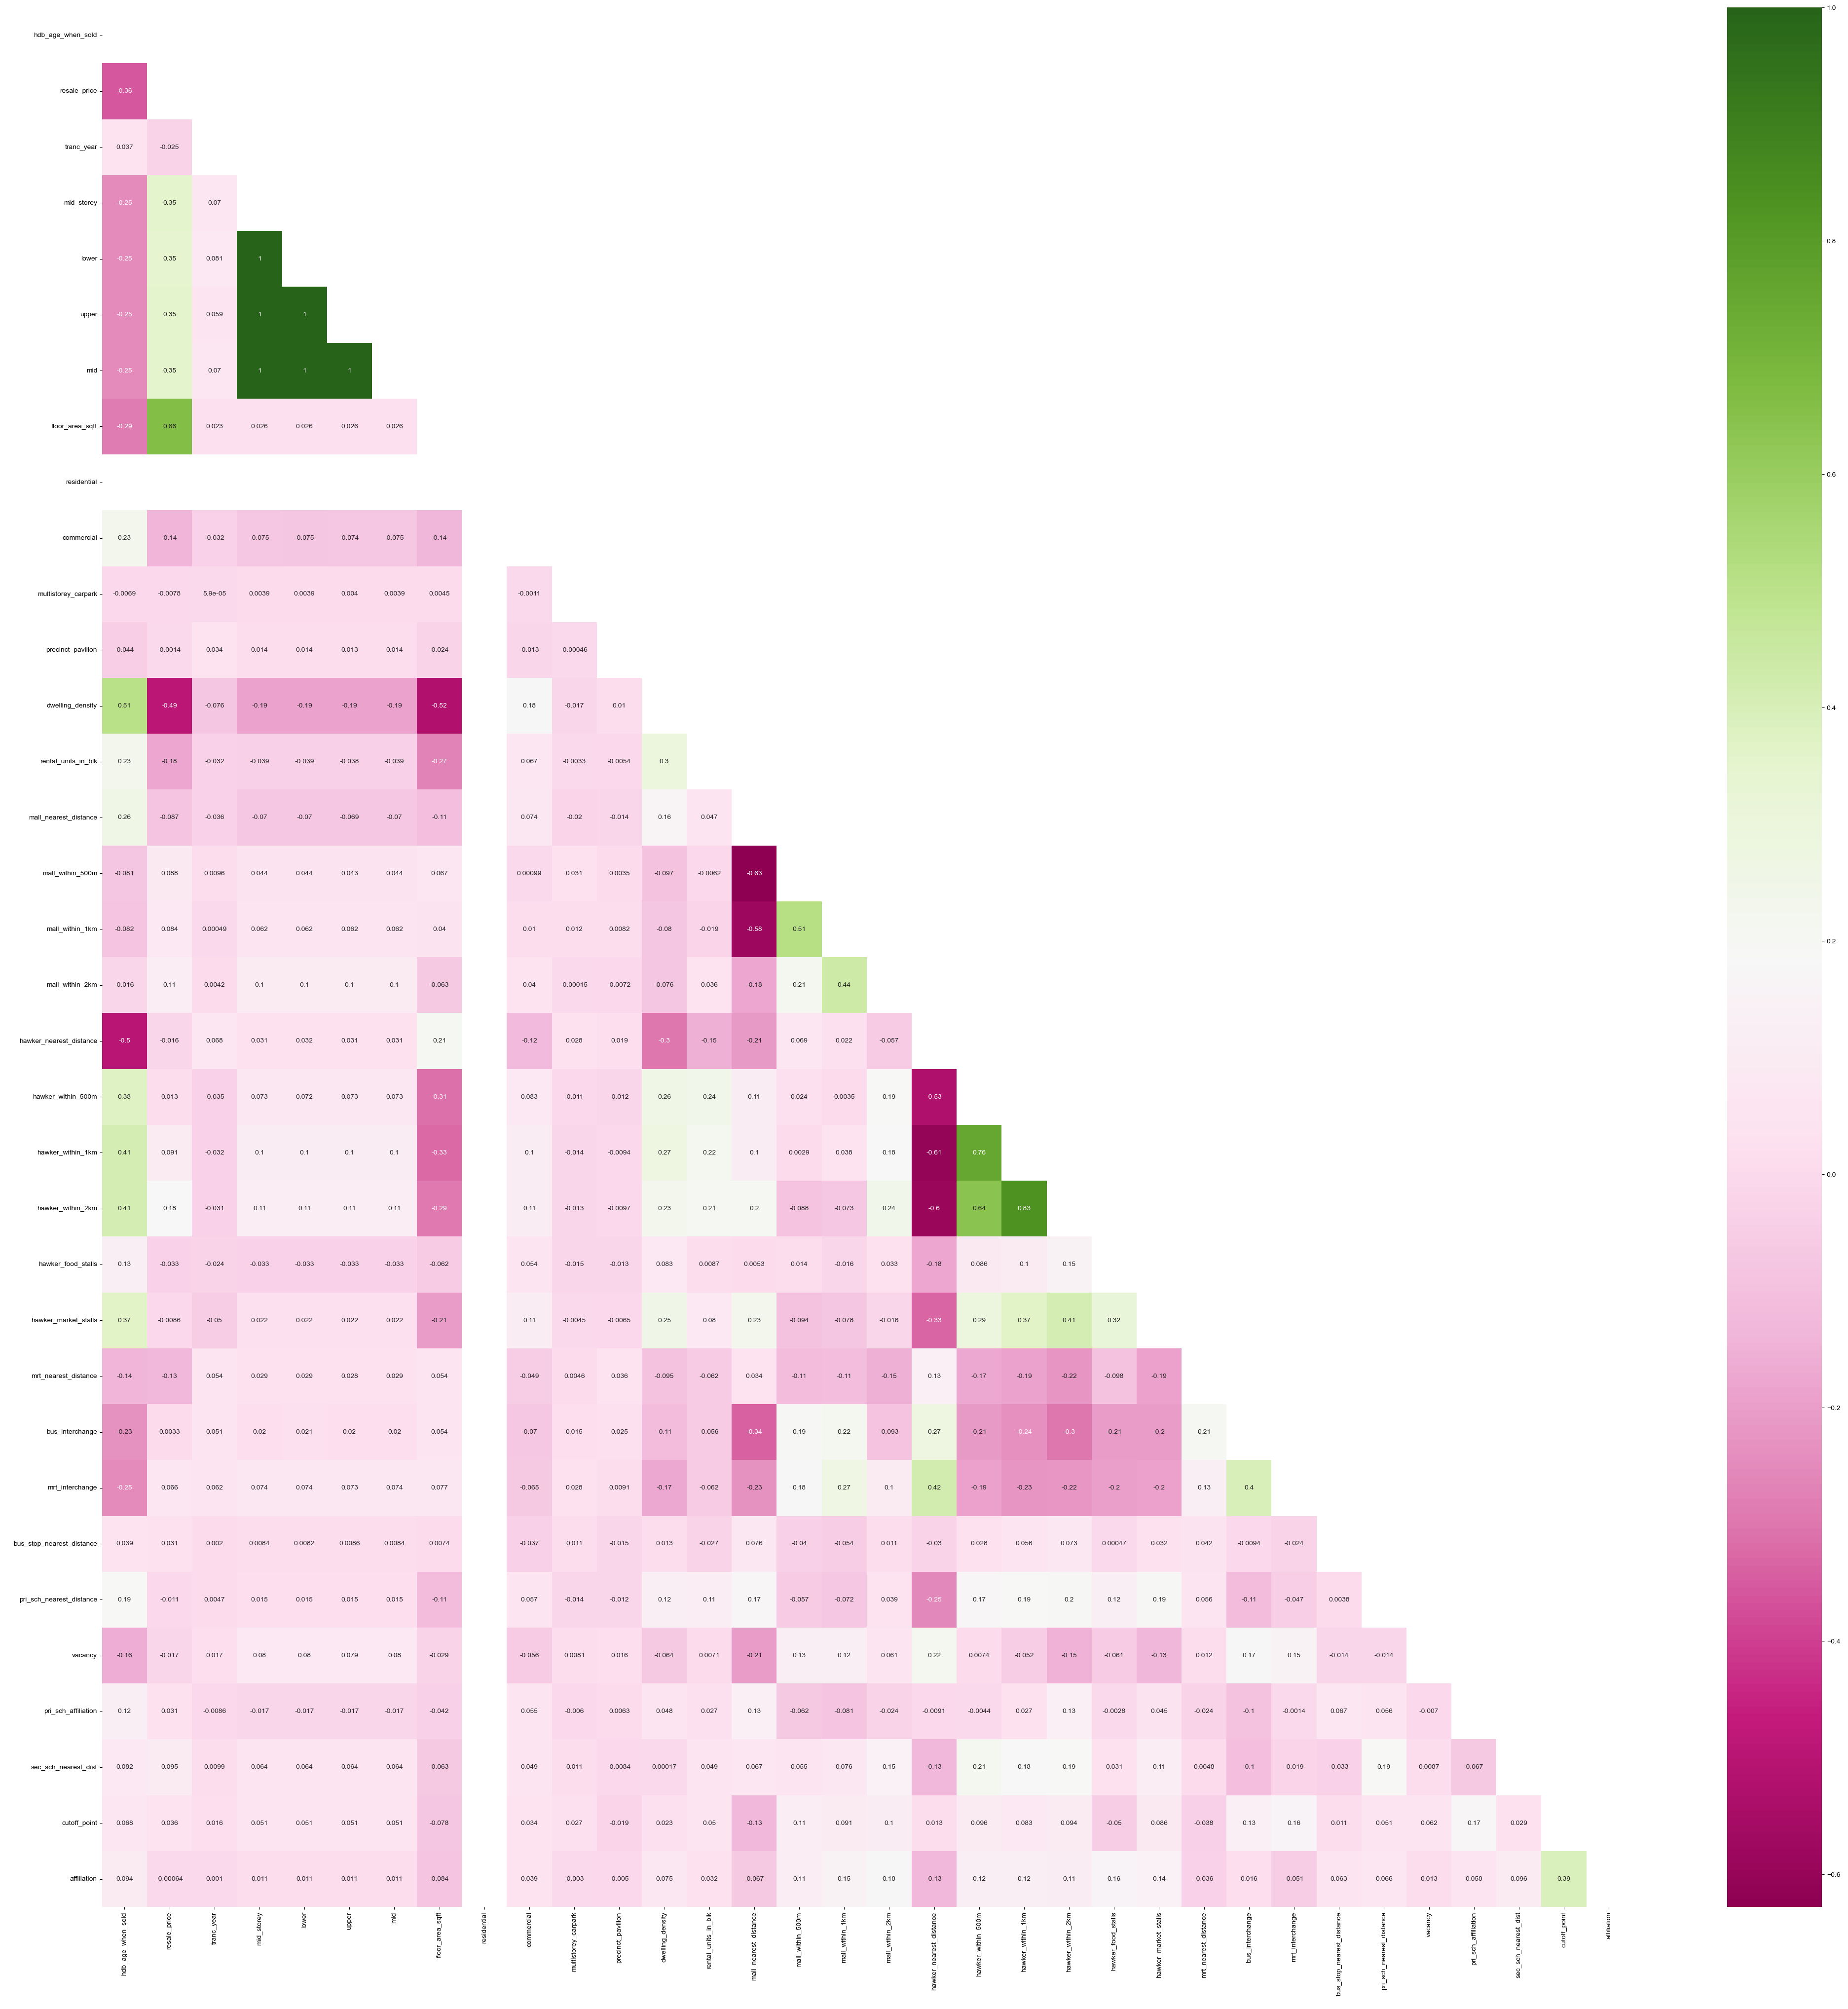

In [25]:
# to do initial correlation heatmap to see possible correlation between remaining numerical variables

# set up mask to be "True" in the upper triangle since it will be symmetrical
mask = np.zeros_like(df_hdb.select_dtypes(include=["int32","int64","float64"]).corr(numeric_only = True))
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (50,50))
sns.heatmap(df_hdb.select_dtypes(include=["int32","int64","float64"]).corr(numeric_only=True), mask = mask, annot = True, cmap="PiYG")
sns.set(rc={'figure.figsize':(50,50),
            "xtick.bottom" : True, "ytick.left" : True})

Rationale:

Based on the intial heatmap, we can see that there are some groups of variables which are very strongly correlated to each other: (a) lower, mid, upper, (b) hawker cluster and (c) malls cluster.

Hence we will need to remove them or choose 1 variable out of the group to keep. This is to reduce multicollinearity when we do the modelling later on for prediction of resale price.

As for the gap on residential, upon checking with the csv, it is revealed that it is all filled in as yes (aka 1) and it's definition is "if resale flat has residential units in the same block" - since it is a hdb, there will be residential units in that block. We can proceed to drop this column as it is not necessary.

In [26]:
# drop further columns
df_hdb.drop(["lower","upper","mid","residential",
             "hawker_within_500m","hawker_within_1km",
             "mall_within_500m", "mall_within_1km"], axis='columns', inplace=True) 

# check shape to ensure columns dropped 
df_hdb.shape

(149805, 31)

Rationale:

"lower", "mid", "upper" columns have been dropped since we already have a "mid_storey" column that represents the median floor in that block.
For malls, we only kept the column within 2km because logically it will also encompass those within 500m and 1 km.

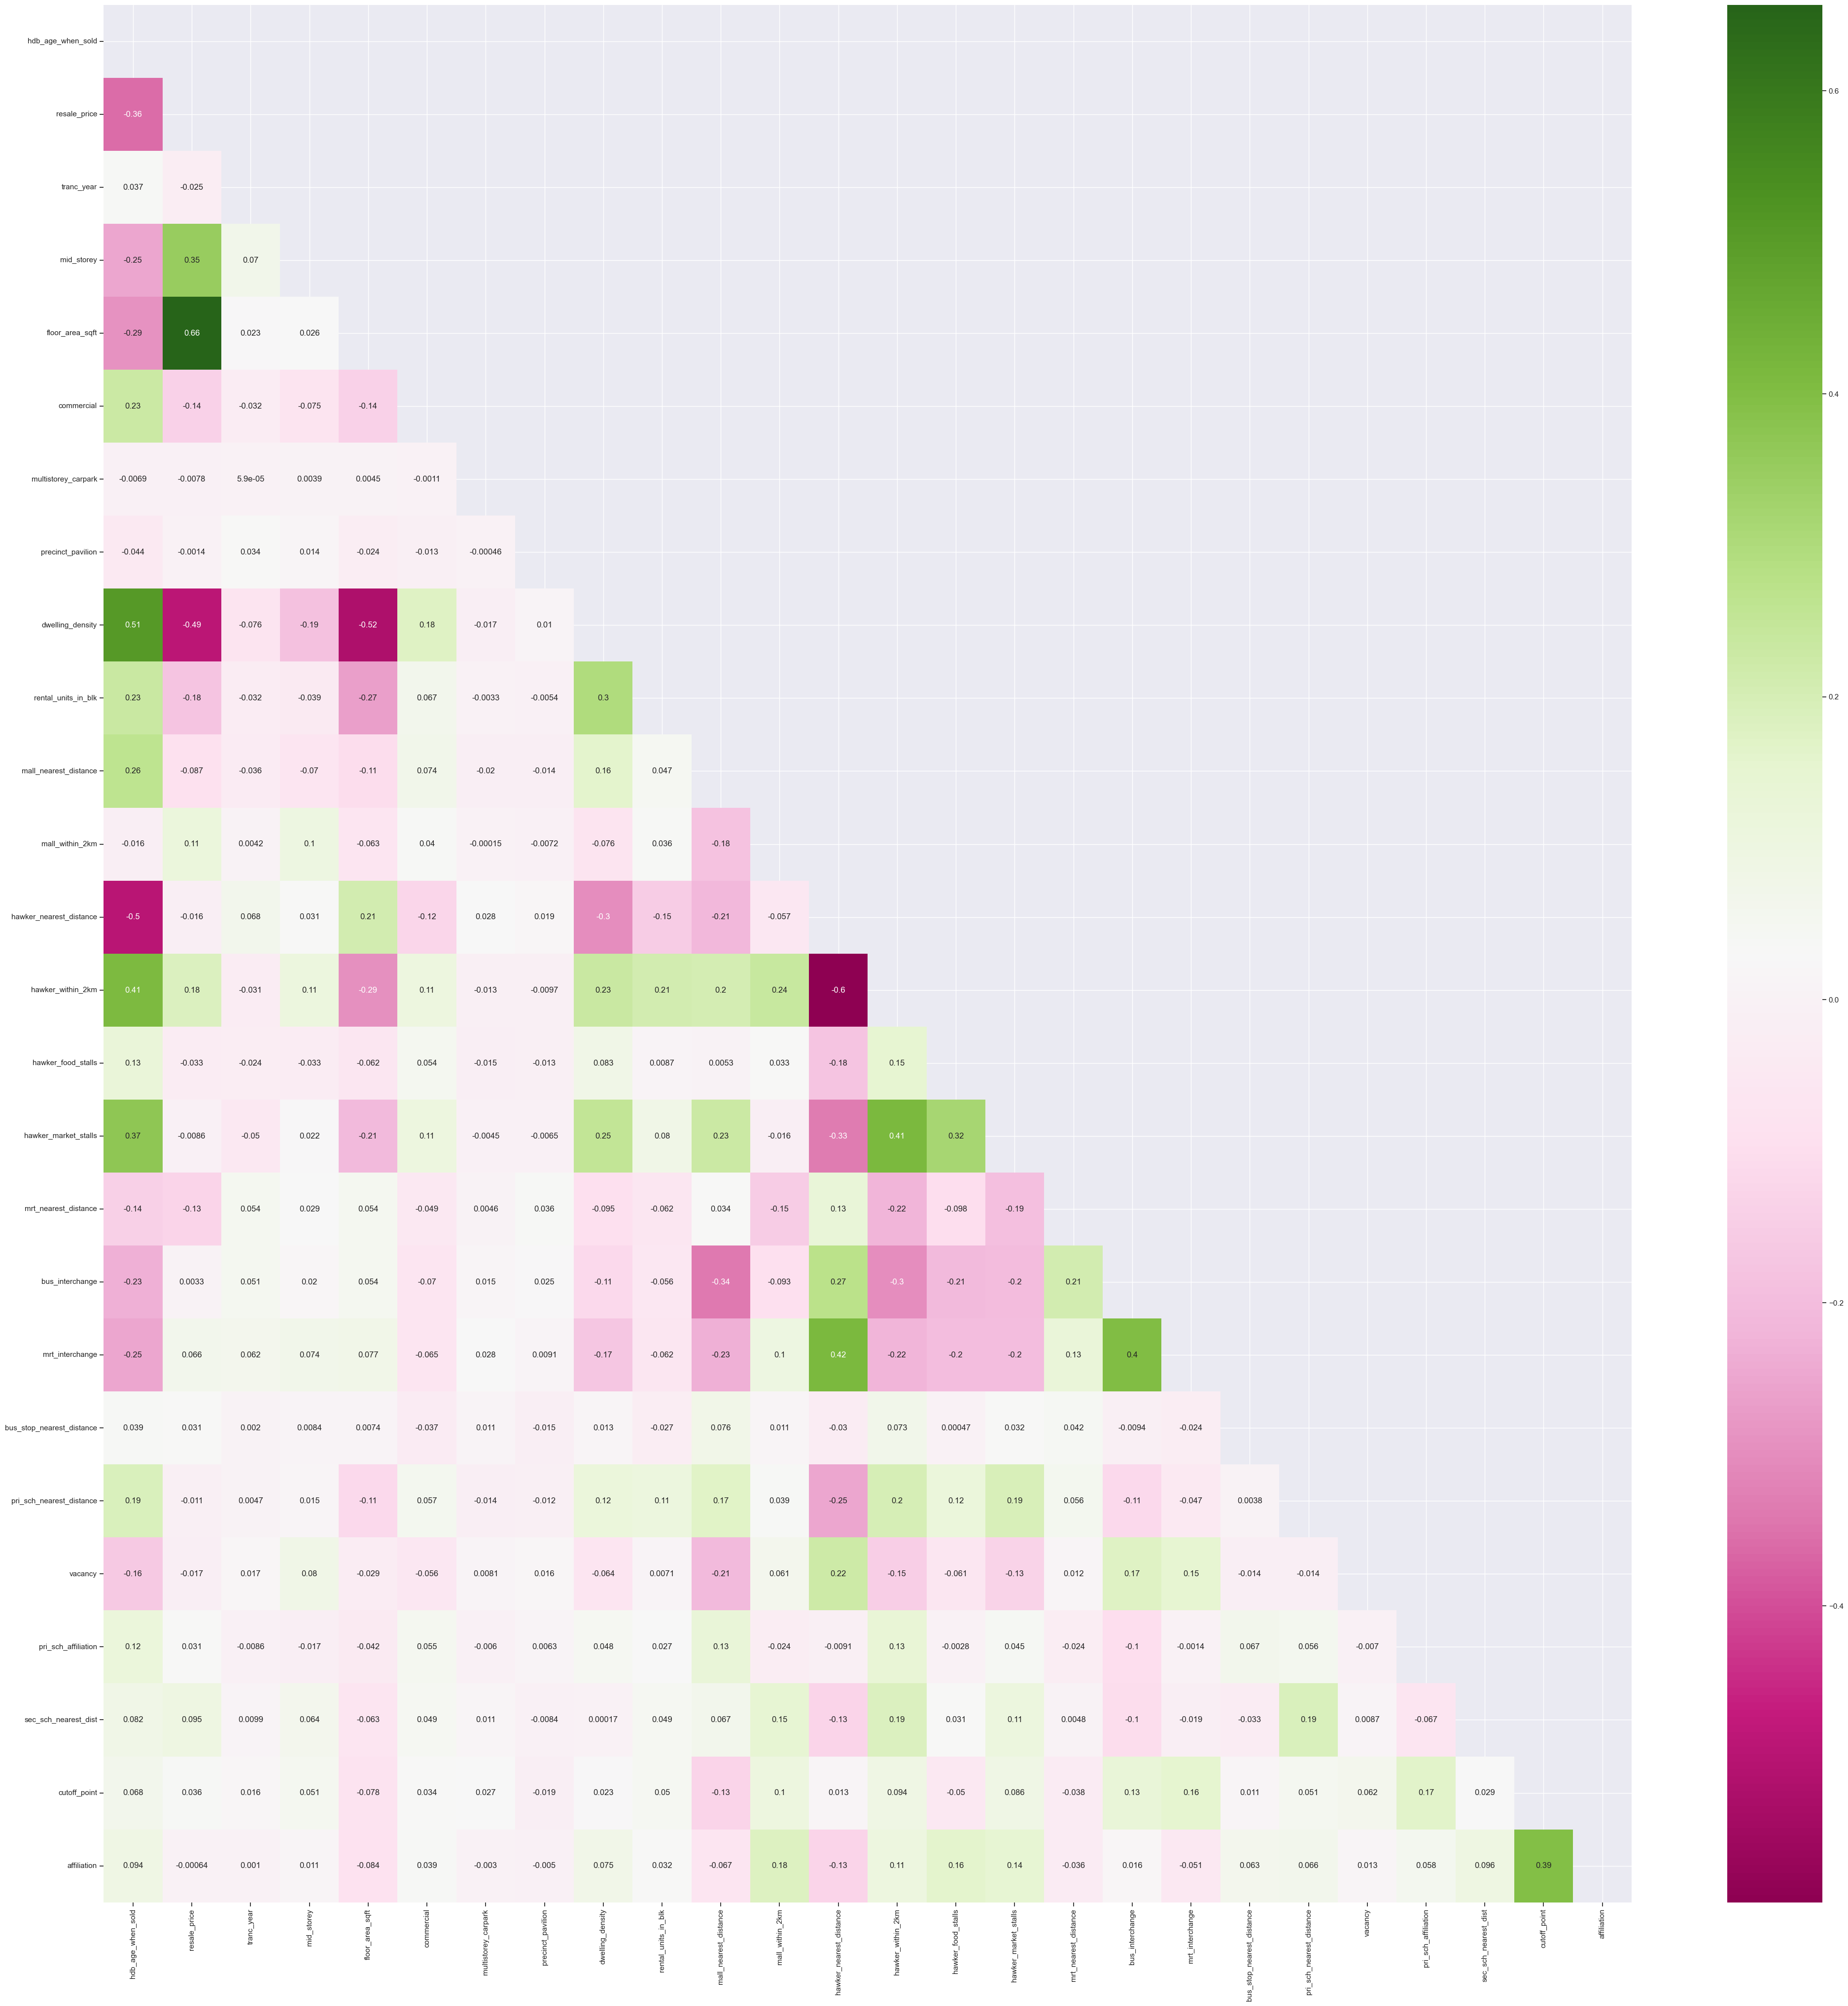

In [27]:
# recheck the heatmap

# set up mask to be "True" in the upper triangle since it will be symmetrical
mask = np.zeros_like(df_hdb.select_dtypes(include=["int32","int64","float64"]).corr(numeric_only = True))
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (50,50))
sns.heatmap(df_hdb.select_dtypes(include=["int32","int64","float64"]).corr(numeric_only=True), mask = mask, annot = True, cmap="PiYG")
sns.set(rc={'figure.figsize':(50,50),
            "xtick.bottom" : True, "ytick.left" : True})

In [28]:
# check the updated df info after second round of data cleaning
df_hdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149805 entries, 0 to 150633
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         149805 non-null  object 
 1   town_region                149805 non-null  object 
 2   flat_type                  149805 non-null  object 
 3   flat_model                 149805 non-null  object 
 4   hdb_age_when_sold          149805 non-null  int64  
 5   resale_price               149805 non-null  float64
 6   tranc_year                 149805 non-null  int64  
 7   tranc_month                149805 non-null  object 
 8   mid_storey                 149805 non-null  int64  
 9   floor_area_sqft            149805 non-null  float64
 10  commercial                 149805 non-null  int64  
 11  multistorey_carpark        149805 non-null  int64  
 12  precinct_pavilion          149805 non-null  int64  
 13  dwelling_density           149805 

Rationale: 

Since we are using linear regression model, we have to check for multicollinearity and it is done using the correlation heatmap.

After checking the heatmaps for multicollinearity and dropping the necessary variables, we are left with the remaining 31 columns. While "id" will not be used as a feature in modelling, we kept it because when submission to kaggle later on we will need to tag the predicted resale price back to the IDs.

<Figure size 3000x2000 with 0 Axes>

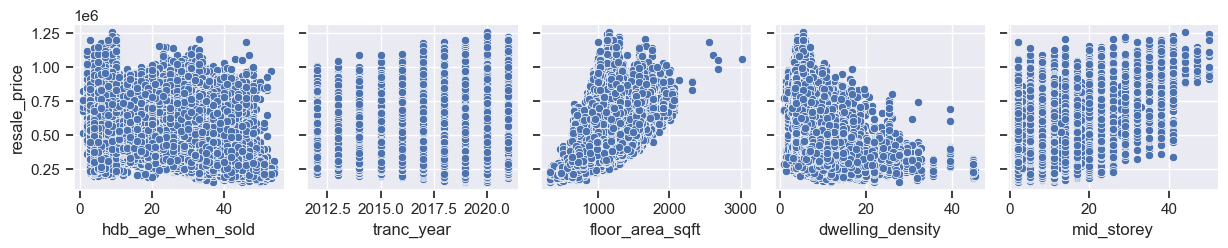

In [29]:
# to see pairplots of our numerical columns vs resale price
# we will group into resale flat related specifications vs amenities

# this is for resale flat related specifications
plt.figure(figsize=(30,20))
sns.pairplot(df_hdb,  
             y_vars=["resale_price"], 
             x_vars=["hdb_age_when_sold", "tranc_year","floor_area_sqft","dwelling_density","mid_storey"]);

Insights:

- As expected, floor_area_sqft follows a generally linear relationship with resale prices. 
- For dwelling density, generally the higher it is, the lower the resale price is. 
- While scatterplot might not be the best to display for tranc_year, we do see that from 2012 to 2020, there seems to be more transactions in general and the upper end of price range seems to be getting higher. 
- mid_storey does not seem to have much effect on resale price - the observation on lesser number pf points the higher the mid storey is, is expected as there are not many HDBs in Singapore with so many storeys.
- For hdb_age_when_sold, as expected we do see that the lower ages do have alot more points than once it passes 40 years - however scatterplot might not be the best to show this relationship.

<Figure size 2500x2000 with 0 Axes>

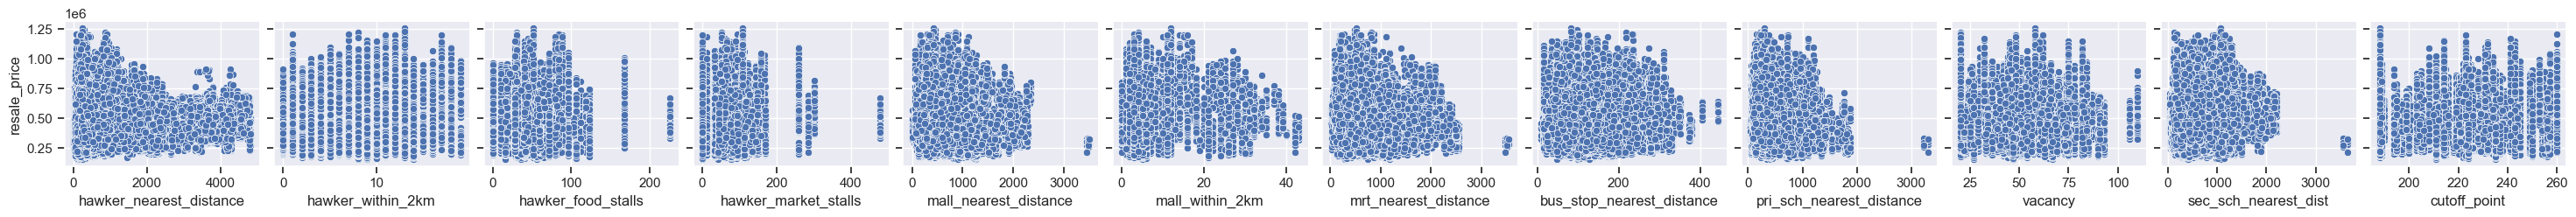

In [30]:
# to see pairplots of our numerical columns vs resale price
# we will group into resale flat related vs amenities

# this is for amenities near resale flat
plt.figure(figsize = (25,20))
sns.pairplot(df_hdb,
             y_vars = ["resale_price"], 
             x_vars = ["hawker_nearest_distance","hawker_within_2km","hawker_food_stalls","hawker_market_stalls",
                       "mall_nearest_distance","mall_within_2km","mrt_nearest_distance","bus_stop_nearest_distance",
                       "pri_sch_nearest_distance","vacancy","sec_sch_nearest_dist","cutoff_point"]);

Insights: 

Generally we do see more HDBs (more points) with higher prices when the amenities are at a shorter distance compared to those which are further away. For vacancies and cutoff_point, they do not have an obvious relationship to resale prices. Overall, homoscedasticity seems to be accounted for.

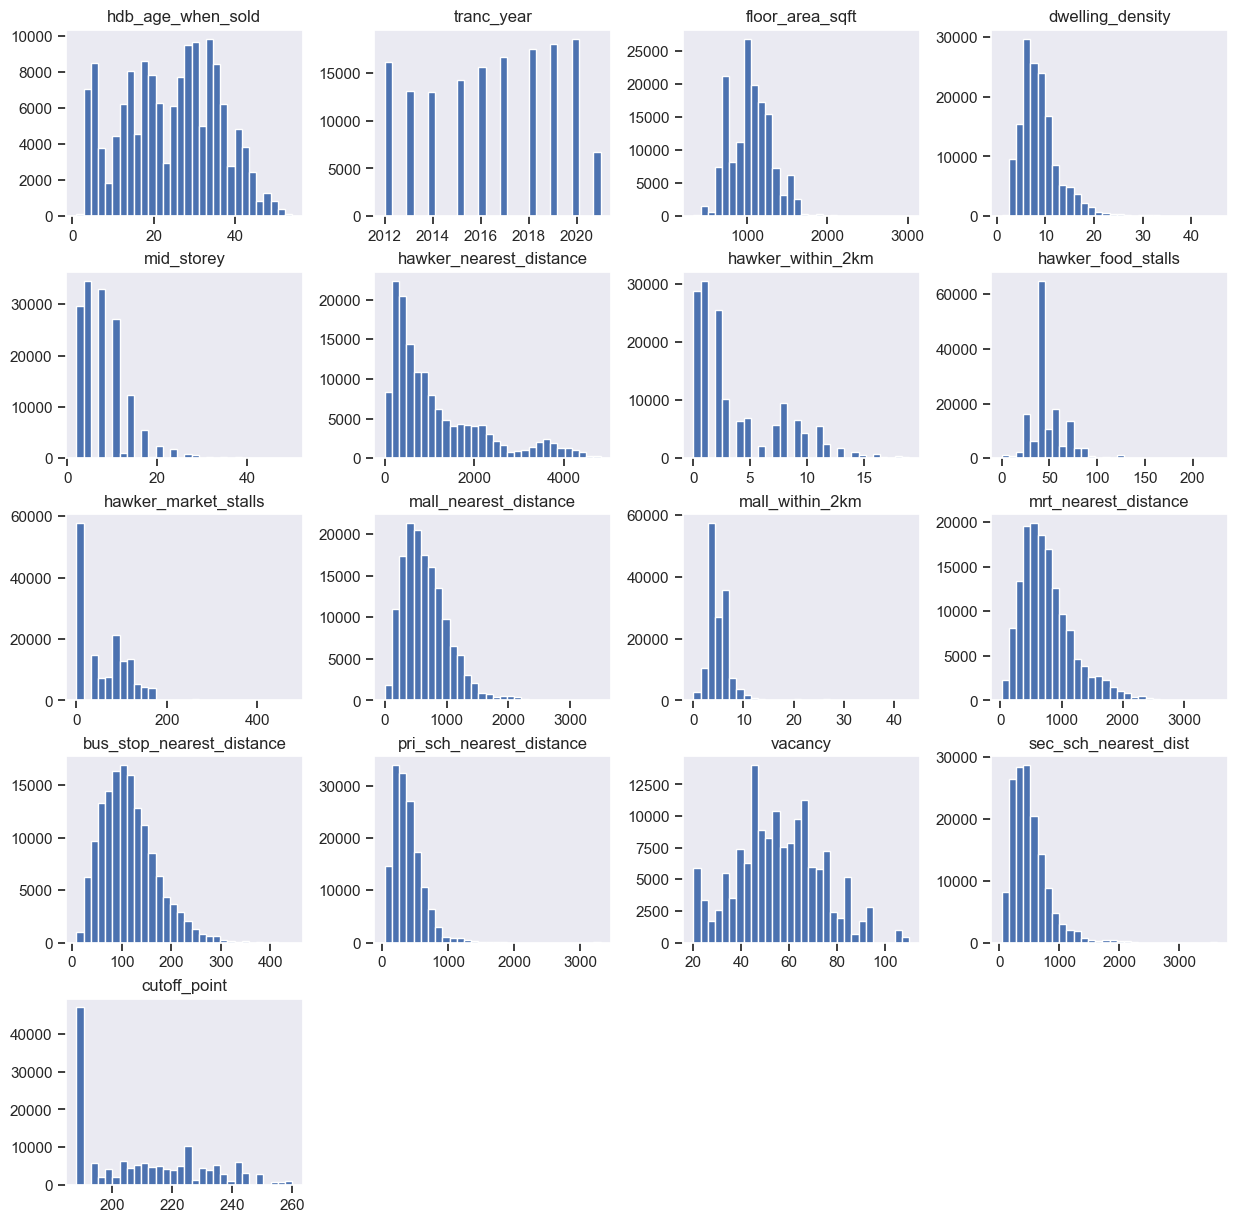

In [31]:
# to see distribution of our numerical columns (excluding boolean-ed columns)
df_hdb.hist(column = ["hdb_age_when_sold", "tranc_year","floor_area_sqft","dwelling_density","mid_storey",
                       "hawker_nearest_distance","hawker_within_2km","hawker_food_stalls","hawker_market_stalls",
                       "mall_nearest_distance","mall_within_2km","mrt_nearest_distance","bus_stop_nearest_distance",
                       "pri_sch_nearest_distance","vacancy","sec_sch_nearest_dist","cutoff_point"], grid = False, figsize = (15, 15), bins = 30)

plt.show();

Insights:

Most of our continous variables generally follow a normal distribution.

### 4. Further EDA / Preliminary plots

In [32]:
# summary statistics
# catgorical columns not included 
df_hdb.describe().T

,count,mean,std,min,25%,50%,75%,max
hdb_age_when_sold,149805.0,24.149875,11.824823,1.000000,15.000000,25.000000,33.000000,5.400000e+01
resale_price,149805.0,448662.064255,143212.531062,150000.000000,346000.000000,420000.000000,520000.000000,1.258000e+06
tranc_year,149805.0,2016.466513,2.742246,2012.000000,2014.000000,2017.000000,2019.000000,2.021000e+03
mid_storey,149805.0,8.263609,5.482182,2.000000,5.000000,8.000000,11.000000,5.000000e+01
floor_area_sqft,149805.0,1046.562426,263.060119,333.684000,807.300000,1022.580000,1205.568000,3.013920e+03
commercial,149805.0,0.191930,0.393819,0.000000,0.000000,0.000000,0.000000,1.000000e+00
multistorey_carpark,149805.0,0.000280,0.016742,0.000000,0.000000,0.000000,0.000000,1.000000e+00
precinct_pavilion,149805.0,0.000754,0.027455,0.000000,0.000000,0.000000,0.000000,1.000000e+00
dwelling_density,149805.0,8.842310,4.197939,1.000000,5.725000,7.750000,10.923077,4.536364e+01
rental_units_in_blk,149805.0,0.036821,0.188323,0.000000,0.000000,0.000000,0.000000,1.000000e+00


#### (a) Explore relationship of flat type and resale price

C:\Users\const\AppData\Local\Temp\ipykernel_23072\4284763670.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


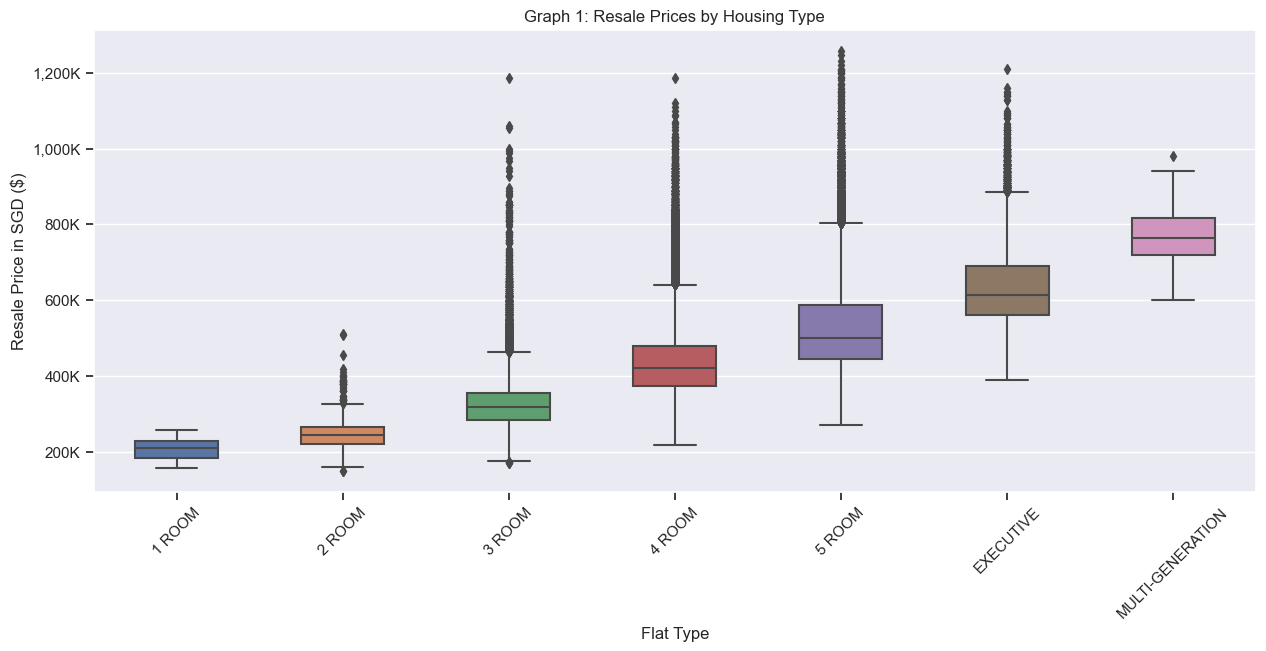

In [33]:
# boxplot to see resale price by flat type
plt.figure(figsize = (15,6))
p = sns.boxplot(x ="flat_type", y = "resale_price", data = df_hdb, width = 0.5,
                order = df_hdb.groupby("flat_type")["resale_price"].median().sort_values().reset_index()["flat_type"].tolist())
plt.suptitle('') # to remove the default title given by sns

# setting the resale price labels on the y-axis
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)

# setting the x-axis label rotation
plt.xticks(rotation=45)

# set title for graph, both axes label
plt.ylabel("Resale Price in SGD ($)")
plt.xlabel("Flat Type")
plt.title("Graph 1: Resale Prices by Housing Type")
plt.show();

In [34]:
# check the number of flats for different flat types
df_hdb["flat_type"].value_counts()

flat_type
4 ROOM              60657
3 ROOM              38905
5 ROOM              36232
EXECUTIVE           11986
2 ROOM               1887
1 ROOM                 82
MULTI-GENERATION       56
Name: count, dtype: int64

In [35]:
# check the median price of different flat types
df_hdb.groupby("flat_type")["resale_price"].median()

flat_type
1 ROOM              209000.0
2 ROOM              245000.0
3 ROOM              318000.0
4 ROOM              420000.0
5 ROOM              500000.0
EXECUTIVE           615000.0
MULTI-GENERATION    765500.0
Name: resale_price, dtype: float64

Insights:

After plotting the boxplot and calculating the median resale prices, we observed there is a continuous "string" of outliers in the 3 room, 4 room, 5 room flat types. For multigeneral, it has a significant higher median price. We will explore further by breaking them down into town regions to see if there is any trends.

C:\Users\const\AppData\Local\Temp\ipykernel_23072\2604126938.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


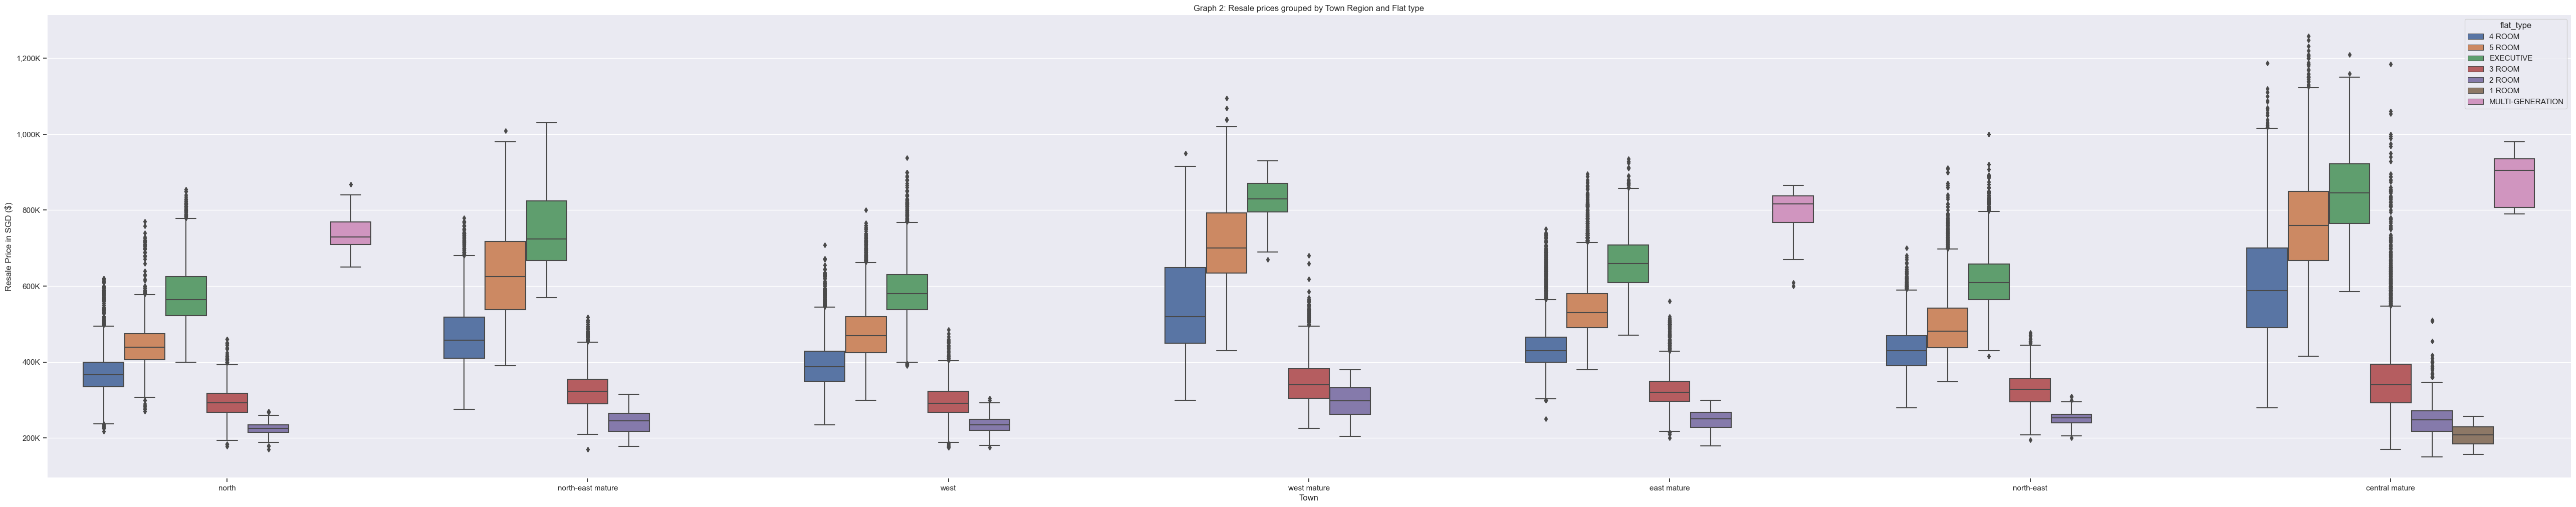

In [36]:
# plot boxplot of resale prices grouped by town and flat type
plt.figure(figsize = (65,12))

# order the plots by median from smallest to largest
order = df_hdb.groupby("town_region")["resale_price"].median().sort_values().reset_index()["town_region"].tolist()

# boxplot
p = sns.boxplot(data = df_hdb, x = "town_region", y = "resale_price", hue = "flat_type", order = order) #whis = (0,100)

# setting the resale price labels on the y-axis
ylabels = ["{:,.0f}".format(x) + "K" for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)

# add in labels for axes and titles for plot
plt.title("Graph 2: Resale prices grouped by Town Region and Flat type")
plt.xlabel("Town")
plt.ylabel("Resale Price in SGD ($)")

# specify where to remove the spine of the plot
sns.despine(right = True, left = False)

In [37]:
# filter out 1 room and multigeneration from flat type
print(f'Numbr of 1 room and  multigeneration flats: {len(df_hdb.loc[(df_hdb["flat_type"] == "1 ROOM") | (df_hdb["flat_type"] == "MULTI-GENERATION")])}')
df_hdb.shape

Numbr of 1 room and  multigeneration flats: 138


(149805, 31)

In [38]:
# drop them from df
df_hdb.drop(df_hdb[df_hdb["flat_type"] == "1 ROOM"].index, inplace = True)
df_hdb.drop(df_hdb[df_hdb["flat_type"] == "MULTI-GENERATION"].index, inplace = True)

print(df_hdb.shape)

(149667, 31)


Insights:

1. Based on Graph 1, we do see generally there are a continuum of outliers for every category except for 1 room and multigenerational flats. We decide to do a value counts and to see the median values of these flat types.
    - We realise that these 2 categories have a very small number, and in addition to that the multigeneration group has a very high median price which could possibly skew the data hence it might not be generalisable to the model. 

2. Furthermore, upon further research we found that 1 room flats are generally only for rental and not for sale hence it will not be something that buyers consider in the market. In the boxplot based on town, they are only in Central region.

3. Based on the boxplot grouped by town and flat type, we see that multigenerational flats are only available in 3 regions - Central, East mature towns and North mature towns only.

As such, we made the decision to not include these 2 types of flats in our modelling. 


#### (b) Explore relationship of resale price and flat model

C:\Users\const\AppData\Local\Temp\ipykernel_23072\4173584396.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


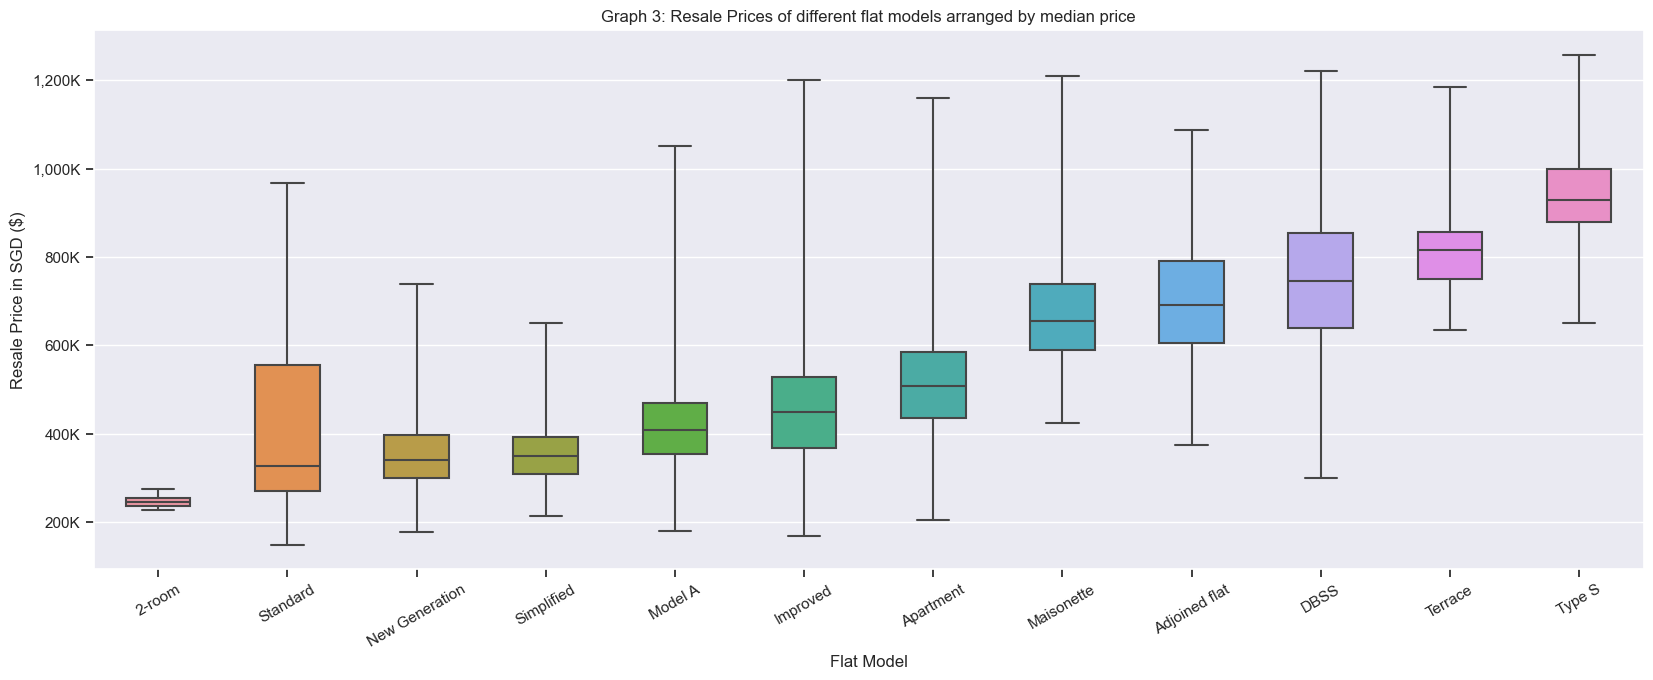

In [39]:
# boxplot to see resale price by flat model

# set size of plot
plt.figure(figsize = (20,7))

# set order of plot - arranged the categories by median price
order_group = df_hdb.groupby("flat_model")["resale_price"].median().sort_values().reset_index()["flat_model"].tolist()

p = sns.boxplot(x = "flat_model", y = "resale_price", data = df_hdb, width = 0.5, order = order_group, whis = (0,100))

# setting the resale price labels on the y-axis
ylabels = ["{:,.0f}".format(x) + "K" for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)

# setting the x-axis label rotation
plt.xticks(rotation = 30)

# set title for graph, both axes label
plt.xlabel("Flat Model")
plt.ylabel("Resale Price in SGD ($)")
plt.title("Graph 3: Resale Prices of different flat models arranged by median price")
plt.show();

In [40]:
# check the number of flats for different flat model
df_hdb["flat_model"].value_counts()

flat_model
Model A           47850
Improved          38305
New Generation    23366
Apartment         20966
Simplified         7238
Standard           4867
Maisonette         4708
DBSS               1639
Type S              369
Adjoined flat       260
Terrace              95
2-room                4
Name: count, dtype: int64

In [41]:
# drop 2-room from df
df_hdb.drop(df_hdb[df_hdb["flat_model"] == "2-room"].index, inplace = True)

# drop adjoined flat from df
df_hdb.drop(df_hdb[df_hdb["flat_model"] == "Adjoined flat"].index, inplace = True)

# check updated value counts for flat model
df_hdb["flat_model"].value_counts()

flat_model
Model A           47850
Improved          38305
New Generation    23366
Apartment         20966
Simplified         7238
Standard           4867
Maisonette         4708
DBSS               1639
Type S              369
Terrace              95
Name: count, dtype: int64

Insights:

1. For 2-room, we can see from the boxplot that they have a very small number of them, and as confirmed by value counts, there are only 4 of them hence we will drop this flat model as it is not representative.

2. Based on the boxplot of the  and the value counts, even though "Terrace" have one of the lowest quantities among all the flat models due to most of them being discontinued by HDB, they have the second highest median resale prices - likely due to the rarity factor. We will further explore this below.

3. We also see that adjoined flat even though have the second lowest quantity, also command a higher price than norm - partly due to its configuration of 2 HDB flats joined together - however these 2 HDB flats can be of multiple configurations i.e. 2 room + 2 room, 2 room + 3 room, 2 room + executive etc. Hence we decide to drop this category as we want the model to be able to generalise better. 

4. Based on this boxplot, we can potentially categorise the groups even more to have a less sparse model -  we will do that before we do train test split.

C:\Users\const\AppData\Local\Temp\ipykernel_23072\2208484814.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  box_terrace.set_yticklabels(ylabels)
C:\Users\const\AppData\Local\Temp\ipykernel_23072\2208484814.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  box_3room.set_yticklabels(ylabels)
C:\Users\const\AppData\Local\Temp\ipykernel_23072\2208484814.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  box_4room.set_yticklabels(ylabels)


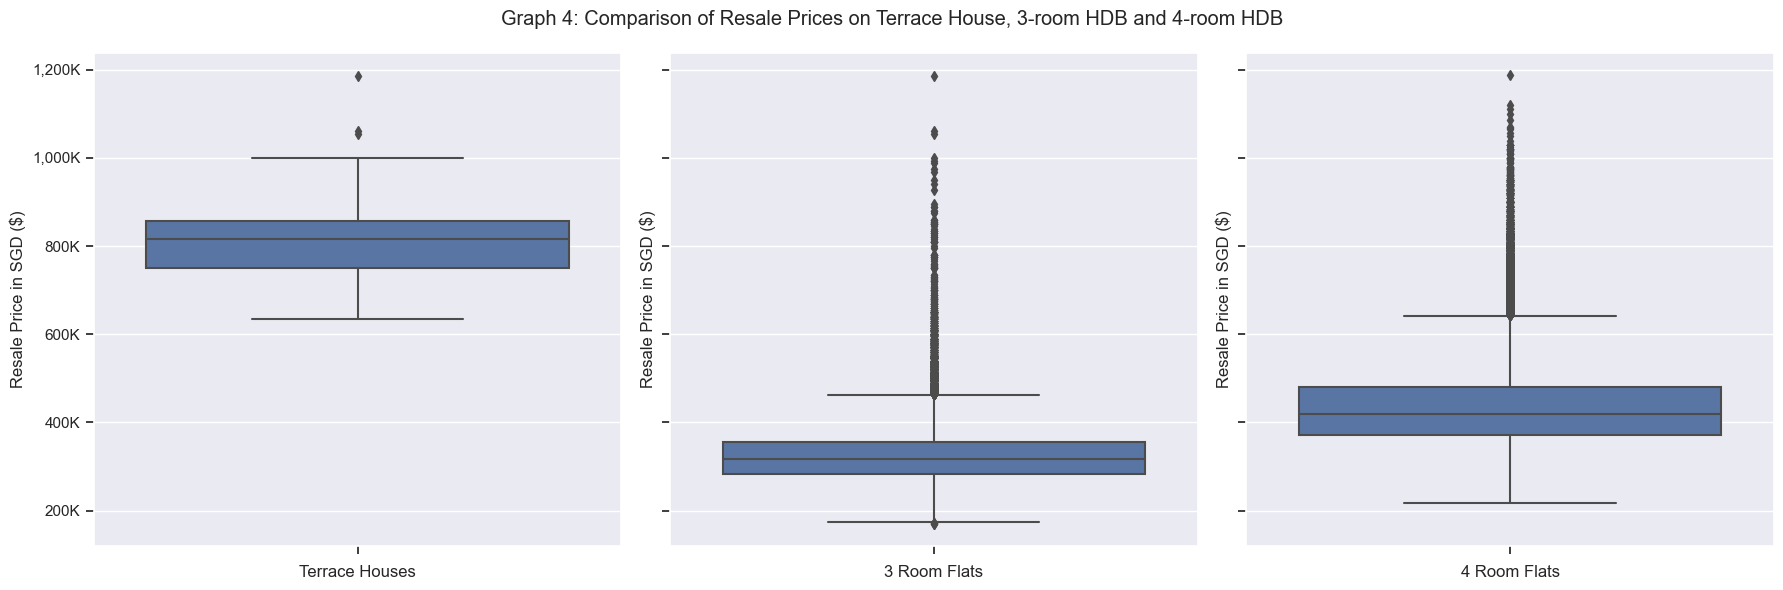

In [42]:
# Terrace Vs 3-room HDB Vs 4-room HDB

# to create the "grid" to put plots side by side
# plt.subplot(total how many rows, total how many columns, plot size)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6), sharey=True) 


# PLOT 1 - plot for terrace HDB resale prices
price_terrace = df_hdb.loc[(df_hdb["flat_model"] == "Terrace")]["resale_price"]

# plotting barplot 
box_terrace = sns.boxplot(y = price_terrace, data = df_hdb, ax = axes[0])

# setting the resale price labels on the y-axis
ylabels = ["{:,.0f}".format(x) + "K" for x in box_terrace.get_yticks()/1000]
box_terrace.set_yticklabels(ylabels)

# setting title of the graphs
box_terrace.set(xlabel = "Terrace Houses", ylabel = "Resale Price in SGD ($)")


# PLOT 2 - plot for 3 room prices
price_3room = df_hdb[(df_hdb["flat_type"] == "3 ROOM")]["resale_price"]

# plotting barplot 
box_3room = sns.boxplot(y = price_3room,  data = df_hdb, ax = axes[1])

# setting the resale price labels on the y-axis
ylabels = ["{:,.0f}".format(x) + "K" for x in box_3room.get_yticks()/1000]
box_3room.set_yticklabels(ylabels)

# setting title of the graphs
box_3room.set(xlabel = "3 Room Flats", ylabel = "Resale Price in SGD ($)")



# PLOT 3 - plot for 4 room prices
price_4room = df_hdb[(df_hdb["flat_type"] == "4 ROOM")]["resale_price"]

# plotting barplot 
box_4room = sns.boxplot(y = price_4room,  data = df_hdb, ax = axes[2])

# setting the resale price labels on the y-axis
ylabels = ["{:,.0f}".format(x) + "K" for x in box_4room.get_yticks()/1000]
box_4room.set_yticklabels(ylabels)

# setting title of the graphs
box_4room.set(xlabel= "4 Room Flats", ylabel = "Resale Price in SGD ($)")

# adjust layout and set overall title
plt.suptitle('Graph 4: Comparison of Resale Prices on Terrace House, 3-room HDB and 4-room HDB')
plt.tight_layout()
plt.show()

In [43]:
# filter to see if outliers in 3 room are due to terrace flat models
df_hdb.loc[(df_hdb["flat_type"] == "3 ROOM") & (df_hdb["resale_price"] > 600000)]["flat_model"].value_counts()

flat_model
Terrace      86
Standard     73
Model A      46
Apartment    26
DBSS         21
Name: count, dtype: int64

In [44]:
# drop them from df
df_hdb.drop(df_hdb[df_hdb["flat_model"] == "Terrace"].index, inplace = True)

print(df_hdb.shape)

(149308, 31)


Rationale:

We decide to do a comparison among these 3 groups because the Terrrace flat model are considered either 3 room or 4 room by HDB only. 
Secondly, based on graph 1, we realised that there are alot of outliers in the 3 room and 4 room HDB cateogries hence we are interested to see if this could be contributed by the Terrace houses since they are rare (only 95 of them in our dataset), and thus buyers are likely to pay for them at a higher cost in comparison to the average HDB.

Insights: 

From the boxplot, we could see that there is a possibility of the terrace houses contributing to the outliers, after the $600K mark. To confirm our assumptions, we decide to check the actual count of Terrace flat models by filtering to (a) 3 room flat type, (b) resale price above $600k and grouped by flat model, we can see that the bulk of the outliers (86 out of 95) are indeed contributed by "Terrace" for 3 room. As such, to prevent them from skewing our data from predicting 3 room prices, we will drop Terrace from flat model; furthermore they are discontinued by HDB hence the amount of them in the resale market is quite low.

C:\Users\const\AppData\Local\Temp\ipykernel_23072\1292916603.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  box_s.set_yticklabels(ylabels)
C:\Users\const\AppData\Local\Temp\ipykernel_23072\1292916603.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  box_4room.set_yticklabels(ylabels)
C:\Users\const\AppData\Local\Temp\ipykernel_23072\1292916603.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  box_5room.set_yticklabels(ylabels)


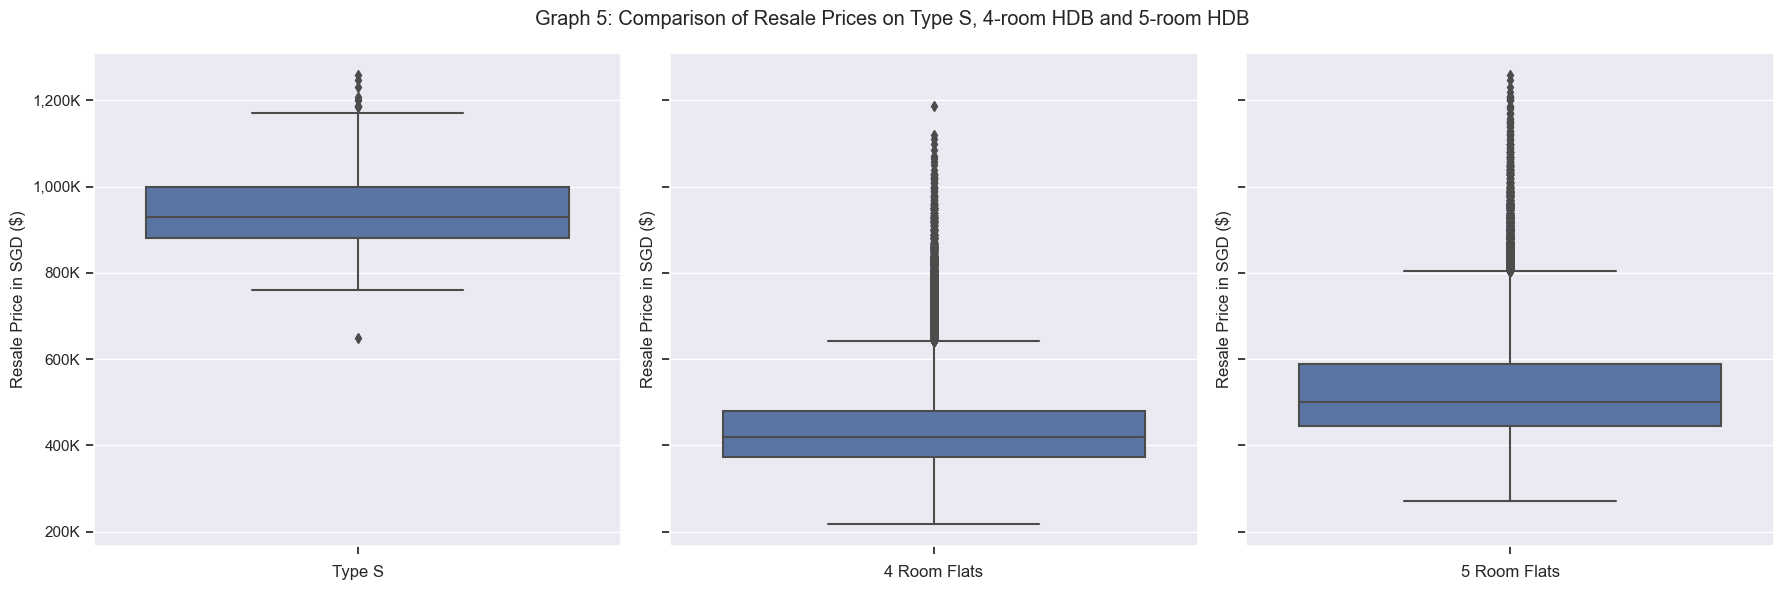

In [45]:
# Type S Vs 4-room HDB Vs 5-room HDB

# to create the "grid" to put plots side by side
# plt.subplot(total how many rows, total how many columns, plot size)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6), sharey=True) 


# PLOT 1 - plot for Type S resale prices
price_s = df_hdb.loc[(df_hdb["flat_model"] == "Type S")]["resale_price"]

# plotting barplot 
box_s = sns.boxplot(y = price_s, data = df_hdb, ax = axes[0])

# setting the resale price labels on the y-axis
ylabels = ["{:,.0f}".format(x) + "K" for x in box_s.get_yticks()/1000]
box_s.set_yticklabels(ylabels)

# setting title of the graphs
box_s.set(xlabel = "Type S", ylabel = "Resale Price in SGD ($)")


# PLOT 2 - plot for 5 room prices
price_4room = df_hdb[(df_hdb["flat_type"] == "4 ROOM")]["resale_price"]

# plotting barplot 
box_4room = sns.boxplot(y = price_4room,  data = df_hdb, ax = axes[1])

# setting the resale price labels on the y-axis
ylabels = ["{:,.0f}".format(x) + "K" for x in box_4room.get_yticks()/1000]
box_4room.set_yticklabels(ylabels)

# setting title of the graphs
box_4room.set(xlabel= "4 Room Flats", ylabel = "Resale Price in SGD ($)")


# PLOT 3 - plot for 5 room prices
price_5room = df_hdb[(df_hdb["flat_type"] == "5 ROOM")]["resale_price"]

# plotting barplot 
box_5room = sns.boxplot(y = price_5room,  data = df_hdb, ax = axes[2])

# setting the resale price labels on the y-axis
ylabels = ["{:,.0f}".format(x) + "K" for x in box_5room.get_yticks()/1000]
box_5room.set_yticklabels(ylabels)

# setting title of the graphs
box_5room.set(xlabel= "5 Room Flats", ylabel = "Resale Price in SGD ($)")


# adjust layout and set overall title
plt.suptitle('Graph 5: Comparison of Resale Prices on Type S, 4-room HDB and 5-room HDB')
plt.tight_layout()
plt.show()

In [46]:
# filter to see if outliers in 4 room are due to Type S flat models
df_hdb.loc[(df_hdb["flat_type"] == "4 ROOM") & (df_hdb["resale_price"] > 600000)]["flat_model"].value_counts()

flat_model
Model A           4493
DBSS               469
Type S             242
Apartment          222
Improved           104
New Generation      58
Maisonette          36
Simplified           6
Standard             4
Name: count, dtype: int64

In [47]:
# filter to see if outliers in 5 room are due to Type S flat models
df_hdb.loc[(df_hdb["flat_type"] == "5 ROOM") & (df_hdb["resale_price"] > 600000)]["flat_model"].value_counts()

flat_model
Improved      5028
Standard       886
DBSS           856
Apartment      588
Model A        487
Maisonette     226
Type S         127
Name: count, dtype: int64

Rationale:

We decide to do a comparison among these 3 groups because the S type flat model are considered either 4 room or 5 room by HDB only and they are only available specifically at Pinnacle @ Duxton.
Secondly, based on graph 3, Type S has the highest median resale prices and having only 369 units, we wanted to see if they contribute significantly to the outliers that we see in our 4 room and 5 room HDB flat types.

Insights: 

From the boxplot, we could see that there might be a possibility of the Type S flats contributing to the outliers, after the $600K mark. However upon filtering to check the exact counts, they did not contribute that much in the 5 room flat type as compared to the 4 room flat type. Being a special group of HDB flats, we decide to keep them in the dataset as there is possibility that buyers might specifically want to buy units from Pinnacle @ Duxton since they are available in the market.

In [48]:
# recategorise the type model into even broader categories
regrouped_values = {"Standard":"standard",
                    "New Generation":"standard",
                    "Simplified":"standard",
                    "Model A":"standard",
                    "Improved":"standard",
                    "Apartment":"standard",
                    "DBSS": "private built",
                    "Type S":"private built",
                    "Maisonette":"maisonette"
                    }

df_hdb = df_hdb.replace({'flat_model': regrouped_values})

# see updated categories of flat models
df_hdb['flat_model'].unique()

array(['standard', 'maisonette', 'private built'], dtype=object)

C:\Users\const\AppData\Local\Temp\ipykernel_23072\1444452200.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


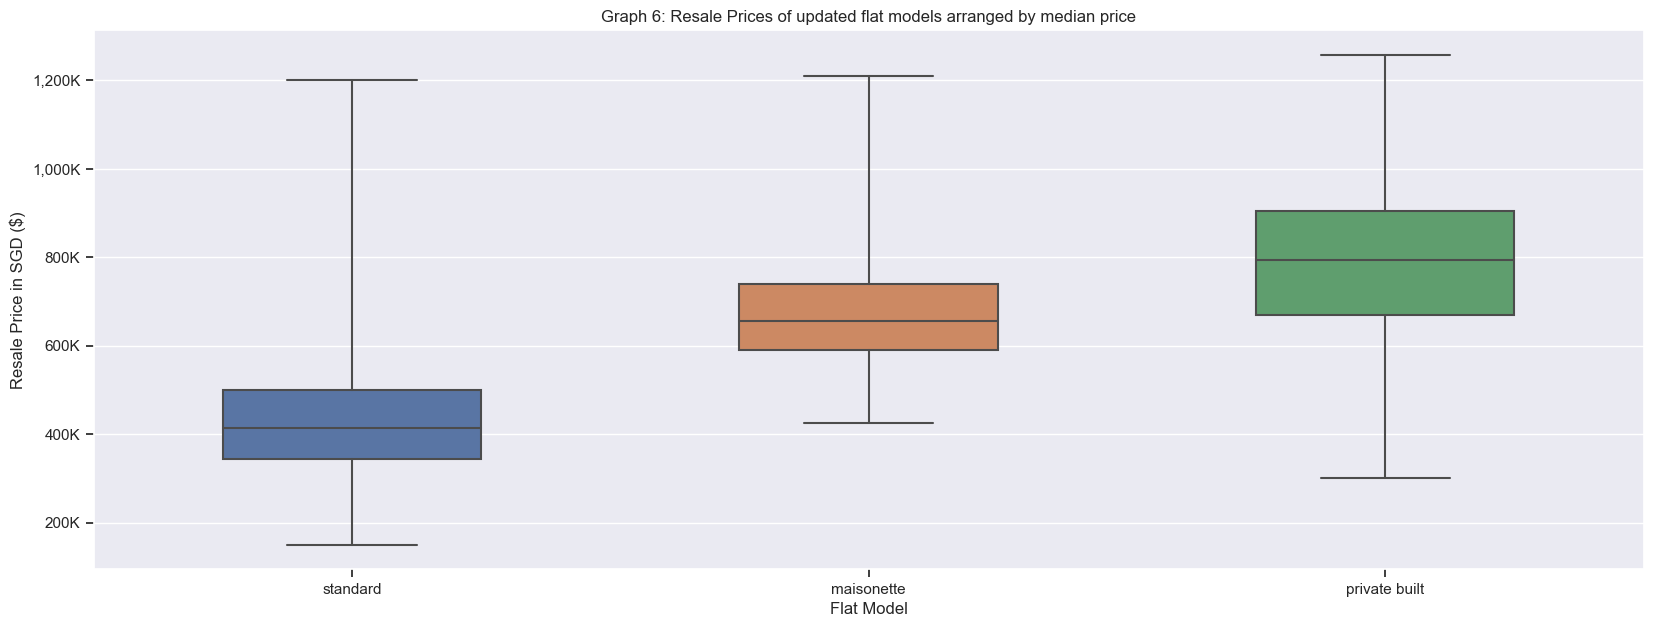

In [49]:
# updated boxplot to see resale price by updated flat model

# set size of plot
plt.figure(figsize = (20,7))

# set order of plot - arranged the categories by median price
order_group = df_hdb.groupby("flat_model")["resale_price"].median().sort_values().reset_index()["flat_model"].tolist()

p = sns.boxplot(x = "flat_model", y = "resale_price", data = df_hdb, width = 0.5, order = order_group, whis = (0,100))

# setting the resale price labels on the y-axis
ylabels = ["{:,.0f}".format(x) + "K" for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)

# setting the x-axis label rotation
plt.xticks

# set title for graph, both axes label
plt.xlabel("Flat Model")
plt.ylabel("Resale Price in SGD ($)")
plt.title("Graph 6: Resale Prices of updated flat models arranged by median price")
plt.show();

### Summary of EDA:

- to check for LINEM for linear regression modelling
- explored relationship of price in relation to flat type and flat model and removed categories (2 room, Terrace, Adjoined flat) that might potentially skew the prediction models
    - further recategorize flat models to broader categories

### 5. Define features/ target and perform train/test/split

In [50]:
# last check of columns and dtypes before we do train test split
df_hdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149308 entries, 0 to 150632
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         149308 non-null  object 
 1   town_region                149308 non-null  object 
 2   flat_type                  149308 non-null  object 
 3   flat_model                 149308 non-null  object 
 4   hdb_age_when_sold          149308 non-null  int64  
 5   resale_price               149308 non-null  float64
 6   tranc_year                 149308 non-null  int64  
 7   tranc_month                149308 non-null  object 
 8   mid_storey                 149308 non-null  int64  
 9   floor_area_sqft            149308 non-null  float64
 10  commercial                 149308 non-null  int64  
 11  multistorey_carpark        149308 non-null  int64  
 12  precinct_pavilion          149308 non-null  int64  
 13  dwelling_density           149308 

In [51]:
# dumify our categorical columns
columns_to_dummify = ["town_region", "tranc_month", "flat_type", "flat_model"]
df_hdb = pd.get_dummies(columns = columns_to_dummify, drop_first = True, data = df_hdb)

In [52]:
# create our X and y variables
exclude_list = ["id", "resale_price"]
features = [col for col in df_hdb.columns if col not in exclude_list]

X = df_hdb[features]
y = df_hdb["resale_price"]

In [53]:
# do train test split
# we will use 0.8 for train and 0.2 for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [54]:
# instantiate standard scaler to scale our data
ss = StandardScaler()

# fit and transform our X_train data
continuous_columns = ["hdb_age_when_sold","tranc_year","mid_storey","floor_area_sqft","dwelling_density",
                      "hawker_food_stalls","hawker_nearest_distance","hawker_within_2km","mall_nearest_distance","mall_within_2km",
                      "hawker_market_stalls","mrt_nearest_distance","cutoff_point","bus_stop_nearest_distance","pri_sch_nearest_distance",
                      "vacancy","sec_sch_nearest_dist"] 

X_train[continuous_columns] = ss.fit_transform(X_train[continuous_columns])

# transform our X_test data
X_test[continuous_columns] = ss.transform(X_test[continuous_columns])

Rationale:

Since standard scaler should be used only on numerical variables to convert them to be on the same scale for comparison and modelling, we will have to pick these columns out hence we create a variable "continuous_columns". 

Secondly, we should not be scaling on those columns which are already in boolean values to prevent overscaling. 

Thirdly, we should not be scaling on our categorical variables as those should be dummified instead.

## Modelling

In section 6 and 7, we will use 3 models - Linear Regression, Lasso Regularization & Ridge Regularization to train our data on. We will only use ElasticNet as a check to see which regularization method is better, rather than fitting our data on it.

Metrics that we will look at are:
-  R2 scores
- cross validation scores
- RMSE 
to decide which will be the best model to use for resale price prediction.

### 6. Modelling

#### (a) Linear Regression

In [55]:
# instantiate linear regression
linreg = LinearRegression()

# fit the model
linreg.fit(X_train, y_train)

# get the R2 score for training set and testing set
train_score = linreg.score(X_train, y_train)
test_score = linreg.score(X_test, y_test)

In [56]:
# get cross-validation scores
scores_l = cross_val_score(linreg, X_train, y_train, cv = 5)

# get mean cross-validation score
cv_score_linreg = scores_l.mean()

print(f"Training R2 score: {train_score}")
print(f"Test R2 score: {test_score}")
print(f"Cross validation score: {cv_score_linreg}")

Training R2 score: 0.8477318855858245
Test R2 score: 0.8465678755715675
Cross validation score: 0.8475256799449594


In [57]:
# use stats model to see which coefficients are significant in influencing our linear regression model
X_statsmod = sm.add_constant(X)
model_sm = sm.OLS(y, X_statsmod.astype(float)).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                 1.728e+04
Date:                Wed, 10 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:39:09   Log-Likelihood:            -1.8432e+06
No. Observations:              149308   AIC:                         3.686e+06
Df Residuals:                  149259   BIC:                         3.687e+06
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          4.581e+06   1.11e+05     41.399      0.000    4.36e+06     4.8e+06
hdb_age_when_sold             -3950.5244     18.556   -212.902      0.000   -3986.893   -3914.156
tranc_year                    -2103.1568     54.835    -38.354      0.000   -2210.633   -1995.681
mid_storey                     4319.7954     28.889    149.533      0.000    4263.174    4376.417
floor_area_sqft                 290.3783      1.959    148.240      0.000     286.539     294.218
commercial                    -4135.4331    380.876    -10.858      0.000   -4881.943   -3388.924
multistorey_carpark           -5.378e+04   8600.907     -6.253      0.000   -7.06e+04   -3.69e+04
precinct_pavilion              2.333e+04   5261.808      4.435      0.000     1.3e+04    3.36e+04
dwelling_density              -1980.1457     47.411    -41.766      0.000   -2073.070   -1887.222
rental_units_in_blk           -1.088e+04    864.029    -12.595      0.000   -1.26e+04   -9188.688
mall_nearest_distance           -10.0371      0.467    -21.483      0.000     -10.953      -9.121
mall_within_2km               -1255.6484     48.494    -25.893      0.000   -1350.696   -1160.601
hawker_nearest_distance         -17.0203      0.215    -79.259      0.000     -17.441     -16.599
hawker_within_2km              2514.0260     82.937     30.312      0.000    2351.471    2676.581
hawker_food_stalls              -95.0788      8.485    -11.206      0.000    -111.709     -78.449
hawker_market_stalls            230.9993      3.431     67.330      0.000     224.275     237.724
mrt_nearest_distance            -46.7642      0.372   -125.874      0.000     -47.492     -46.036
bus_interchange                7891.6502    378.193     20.867      0.000    7150.400    8632.901
mrt_interchange                6576.3783    406.327     16.185      0.000    5779.985    7372.772
bus_stop_nearest_distance        15.5686      2.636      5.907      0.000      10.403      20.734
pri_sch_nearest_distance         12.9400      0.678     19.084      0.000      11.611      14.269
vacancy                           1.9143      9.103      0.210      0.833     -15.928      19.757
pri_sch_affiliation           -2507.6029    498.536     -5.030      0.000   -3484.724   -1530.482
sec_sch_nearest_dist              6.0546      0.513     11.810      0.000       5.050       7.059
cutoff_point                     70.1064      8.478      8.269      0.000      53.489      86.724
affiliation                    9360.3603    949.017      9.863      0.000    7500.306    1.12e+04
town_region_east mature       -8.527e+04    696.992   -122.343      0.000   -8.66e+04   -8.39e+04
town_region_north             -1.626e+05    849.246   -191.412      0.000   -1.64e+05   -1.61e+05
town_region_north-east        -9.857e+04    8

In [58]:
coefficients = model_sm.params
coefficients_df = pd.DataFrame({'Variable': coefficients.index, 'Coefficient': abs(coefficients).values})

# Sort the DataFrame by 'Coefficient' in ascending order
pd.set_option("display.max_rows", 90)
sorted_coefficients = coefficients_df.sort_values(by='Coefficient', ascending = False)

# Print the sorted coefficients
print(sorted_coefficients)

                         Variable   Coefficient
0                           const  4.581368e+06
27              town_region_north  1.625558e+05
30               town_region_west  1.409969e+05
28         town_region_north-east  9.857056e+04
46            flat_type_EXECUTIVE  9.575949e+04
47       flat_model_private built  8.840223e+04
26        town_region_east mature  8.527238e+04
45               flat_type_5 ROOM  6.672124e+04
29  town_region_north-east mature  5.661394e+04
48            flat_model_standard  5.433213e+04
6             multistorey_carpark  5.378316e+04
44               flat_type_4 ROOM  5.024758e+04
43               flat_type_3 ROOM  3.149655e+04
31        town_region_west mature  2.952260e+04
7               precinct_pavilion  2.333403e+04
9             rental_units_in_blk  1.088217e+04
36                  tranc_month_6  1.002858e+04
35                  tranc_month_5  9.759343e+03
37                  tranc_month_7  9.600776e+03
38                  tranc_month_8  9.397

**Insights:**

The top 3 factors affecting resale price is 
- flats in the North
- flats in the West
- flats in the North-east

when we use linear regression.

#### (b) Lasso Regularization

In [59]:
# instantiate lasso regression via LassoCV and fit training data
# set verbose = 1 to check if it works
# to leave LassoCV decide for what alphas to use, just set n_alpha = how many alpha you want it to try
# if max iter not set, default is 1000
optimum_lasso_alpha = LassoCV(n_alphas = 100, cv = 5)
model_lassocv = optimum_lasso_alpha.fit(X_train, y_train)

# optimal value of alpha
print(optimum_lasso_alpha.alpha_)

93.1694593096537


In [60]:
# get R2 score for training and testing sets
train_score_lassocv = model_lassocv.score(X_train, y_train)
test_score_lassocv = model_lassocv.score(X_test, y_test)

In [61]:
# instantiate lasso regression
lasso = Lasso(alpha = optimum_lasso_alpha.alpha_)

# get cross-validation scores
scores_las = cross_val_score(lasso, X_train, y_train)

# get mean cross-validation score
cv_score_lasso = scores_las.mean()

print(f"Training R2 score for Lasso: {train_score_lassocv}")
print(f"Test R2 score for Lasso: {test_score_lassocv}")
print(f"Cross validation score for Lasso: {cv_score_lasso}")

Training R2 score for Lasso: 0.8464465533542678
Test R2 score for Lasso: 0.8453974063608214
Cross validation score for Lasso: 0.846252252379051


In [62]:
# generate the coefficients of the features for lasso regularisation
coefficients_lassocv = abs(model_lassocv.coef_)
(coefficients_lassocv).shape

(48,)

In [63]:
# create a list of tuples by merging feature name and coefficient
lasso_list = list(zip(features, coefficients_lassocv))

# show the list sorted by coefficient values in descending order
sorted(lasso_list, key = lambda x: x[1], reverse=True)

[('town_region_north', 149927.59054371013),
 ('town_region_west', 129255.14757345393),
 ('town_region_north-east', 86337.03458835075),
 ('flat_model_private built', 84826.24320811135),
 ('floor_area_sqft', 83980.03419557153),
 ('town_region_east mature', 75873.46270716688),
 ('flat_model_standard', 53835.17092693749),
 ('town_region_north-east mature', 48293.21611878011),
 ('hdb_age_when_sold', 46695.436405674205),
 ('flat_type_EXECUTIVE', 36682.334710872674),
 ('mid_storey', 24040.6323695033),
 ('mrt_nearest_distance', 20066.463803849343),
 ('hawker_nearest_distance', 17736.82636404983),
 ('flat_type_5 ROOM', 17212.64568542077),
 ('town_region_west mature', 15577.06103115845),
 ('hawker_within_2km', 13628.62585208764),
 ('hawker_market_stalls', 12296.734294600574),
 ('rental_units_in_blk', 10640.960927088008),
 ('dwelling_density', 8792.401859189136),
 ('flat_type_4 ROOM', 8562.985755204887),
 ('bus_interchange', 7547.224727188958),
 ('mrt_interchange', 6720.584996301771),
 ('affiliat

**Insights:**

The top 3 factors affecting resale price is 
- flats in the North
- flats in the West
- flats in the North-East

when we use lasso regularization.

#### (c) Ridge Regularization

In [64]:
# set up a list of ridge alphas to check 
# generates 100 values
r_alphas = np.logspace(0, 5, 100)

# instantiate RidgeCV to find optimum alpha value
# use that and fit training data
optimum_ridge_alpha = RidgeCV(alphas = r_alphas, cv = 5)
model_ridgecv = optimum_ridge_alpha.fit(X_train, y_train)

# optimal value of alpha
print(optimum_ridge_alpha.alpha_)

1.0


In [65]:
# get the R2 scores for training and testing sets
train_score_ridgecv = model_ridgecv.score(X_train, y_train)
test_score_ridgecv = model_ridgecv.score(X_test, y_test)

In [66]:
# instantiate ridge regression
model_ridge = Ridge(alpha = optimum_ridge_alpha.alpha_)

# obtain cross-validation scores
scores_r = cross_val_score(model_ridge, X_train, y_train)

# obtain MEAN cross-validation score
cv_score_ridge = scores_r.mean()

print(f"Training R2 score for Ridge: {train_score_ridgecv}")
print(f"Test R2 score for Ridge: {test_score_ridgecv}")
print(f"Cross validation score for Ridge: {cv_score_ridge}")

Training R2 score for Ridge: 0.8477317877879044
Test R2 score for Ridge: 0.846568885960398
Cross validation score for Ridge: 0.84752567626707


In [67]:
# generate the coefficients of the features for ridge regularisation
coefficients_ridgecv = abs(model_ridgecv.coef_)
(coefficients_ridgecv).shape

(48,)

In [68]:
# create a list of tuples by merging feature name and coefficient
ridgecv_list = list(zip(features, coefficients_ridgecv))

# show the list sorted by coefficient values in descending order
sorted(ridgecv_list, key = lambda x: x[1], reverse=True)

[('town_region_north', 161863.95505144887),
 ('town_region_west', 140494.1066046479),
 ('town_region_north-east', 98489.13407451702),
 ('flat_type_EXECUTIVE', 95608.48699155137),
 ('flat_model_private built', 89352.99225119036),
 ('town_region_east mature', 84658.6410998701),
 ('floor_area_sqft', 75823.07629533984),
 ('flat_type_5 ROOM', 66905.19759080862),
 ('town_region_north-east mature', 56447.17334176887),
 ('multistorey_carpark', 54829.090709238415),
 ('flat_model_standard', 54399.868552196094),
 ('flat_type_4 ROOM', 50387.85129775265),
 ('hdb_age_when_sold', 46583.96915466797),
 ('flat_type_3 ROOM', 31622.674045956584),
 ('town_region_west mature', 29278.129641628682),
 ('precinct_pavilion', 27995.140261293083),
 ('mid_storey', 23607.18874375113),
 ('mrt_nearest_distance', 20069.55204877865),
 ('hawker_nearest_distance', 18194.202988263587),
 ('hawker_market_stalls', 12741.806491751795),
 ('rental_units_in_blk', 10483.563819164952),
 ('hawker_within_2km', 10163.375512427976),
 (

**Insights:**

The top 3 factors affecting resale price is 
- flats in the North
- flats in the West
- flats in the North-East

when we use ridge regularization.

#### (d) ElasticNet

In [69]:
# if alpha not defined, they will determine for you automatically
# adjusting l1_ratio gives you proportion of L1 vs L2 (1- l1_ratio) regularization
# range for l1_ratio is between 0 to 1
l1_ratios = np.linspace(0.1, 1.0, 20)  # Example values for l1_ratio

optimum_elasticnetcv_ratio = ElasticNetCV(l1_ratio=l1_ratios, cv = 5)
model_elasticnetcv = optimum_elasticnetcv_ratio.fit(X_train, y_train)

# find the best l1_ratio 
best_l1_ratio = model_elasticnetcv.l1_ratio_
print(best_l1_ratio)

# find alpha
best_alpha_value = model_elasticnetcv.alpha_
print(best_alpha_value)

1.0
93.1694593096537


In [70]:
# instantiate elastic net regression
elasticnet = ElasticNet(l1_ratio = best_l1_ratio, alpha = best_alpha_value)

# get cross-validation scores
enet_scores = cross_val_score(elasticnet, X_train, y_train)

# get cross-validation score
cv_score_elasticnet = np.mean(enet_scores)
print(f"Cross validation score for ElasticNet: {cv_score_elasticnet}")

Cross validation score for ElasticNet: 0.846252252379051


**Insights:**

Based on ElasticNet, it chose the l1_ratio = 1 which means that Lasso regularization is preferred and it has the same cross validation score as Lasso regularization.

### 7. Checking MSE and RMSE for all 3 models

#### (a) Linear Regression

In [71]:
# create y_preds 
y_preds_ols = linreg.predict(X_test)

# MSE using sklearn
mse_of_preds_ols = metrics.mean_squared_error(y_test, y_preds_ols) # must be y true, y prediction in this order

# RMSE using sklearn
rmse_of_preds_ols = np.sqrt(metrics.mean_squared_error(y_test, y_preds_ols))

print(f"Mean Squared Errors of OLS model: {mse_of_preds_ols}")
print(f"Root Mean Squared Errors of OLS model: {rmse_of_preds_ols}")

Mean Squared Errors of OLS model: 3130713050.2483044
Root Mean Squared Errors of OLS model: 55952.775179148215


#### (b) Lasso Regularization

In [72]:
# create y_preds 
y_preds_lasso = model_lassocv.predict(X_test)

# MSE using sklearn 
mse_of_preds_l = metrics.mean_squared_error(y_test, y_preds_lasso) # must be y true, y prediction in this order

# RMSE using sklearn
rmse_of_preds_l = np.sqrt(metrics.mean_squared_error(y_test, y_preds_lasso))

print(f"Mean Squared Errors of Lasso model: {mse_of_preds_l}")
print(f"Root Mean Squared Errors of Lasso model: {rmse_of_preds_l}")

Mean Squared Errors of Lasso model: 3154595944.6985226
Root Mean Squared Errors of Lasso model: 56165.789807484434


#### (c) Ridge Regularization

In [86]:
# reate y_preds
y_preds_ridge = model_ridgecv.predict(X_test)

# MSE using sklearn
mse_of_preds_r = metrics.mean_squared_error(y_test, y_preds_ridge) # must be y true, y prediction in this order

# RMSE using sklearn
rmse_of_preds_r = np.sqrt(metrics.mean_squared_error(y_test, y_preds_ridge))

print(f"Mean Squared Errors of Ridge model: {mse_of_preds_r}")
print(f"Root Mean Squared Errors of Ridge model: {rmse_of_preds_r}")

Mean Squared Errors of Ridge model: 3130692433.7215567
Root Mean Squared Errors of Ridge model: 55952.59094735075


Summary of metrics:

|Model|Train R2 score|Test R2 score|Cross-Validation score|RMSE|
|---|---|---|---|---|
|Linear Regression|0.84773189|0.84656788|0.84752567|55952.775|
|Lasso Regularization|0.84644669|0.84539756|0.84625239|56165.762|
|Ridge Regularization|0.84773179|0.84658886|0.84752568|55952.591|

### 8. Plotting to show features that influence resale price based on Ridge Regularization

In [74]:
# get the coefficients from ridge regularization model
no_abs_coefficients_ridgecv = model_ridgecv.coef_
no_abs_ridgecv_list = list(zip(features, no_abs_coefficients_ridgecv))
sorted(no_abs_ridgecv_list, key = lambda x: x[1], reverse=True)

# create the dataframe for plotting
df_coeff = pd.DataFrame(no_abs_ridgecv_list, columns=["feature", "coefficients"])
df_coeff

,feature,coefficients
0,hdb_age_when_sold,-46583.969155
1,tranc_year,-5817.756688
2,mid_storey,23607.188744
3,floor_area_sqft,75823.076295
4,commercial,-4388.267348
5,multistorey_carpark,-54829.090709
6,precinct_pavilion,27995.140261
7,dwelling_density,-8303.674099
8,rental_units_in_blk,-10483.563819
9,mall_nearest_distance,-3619.438754


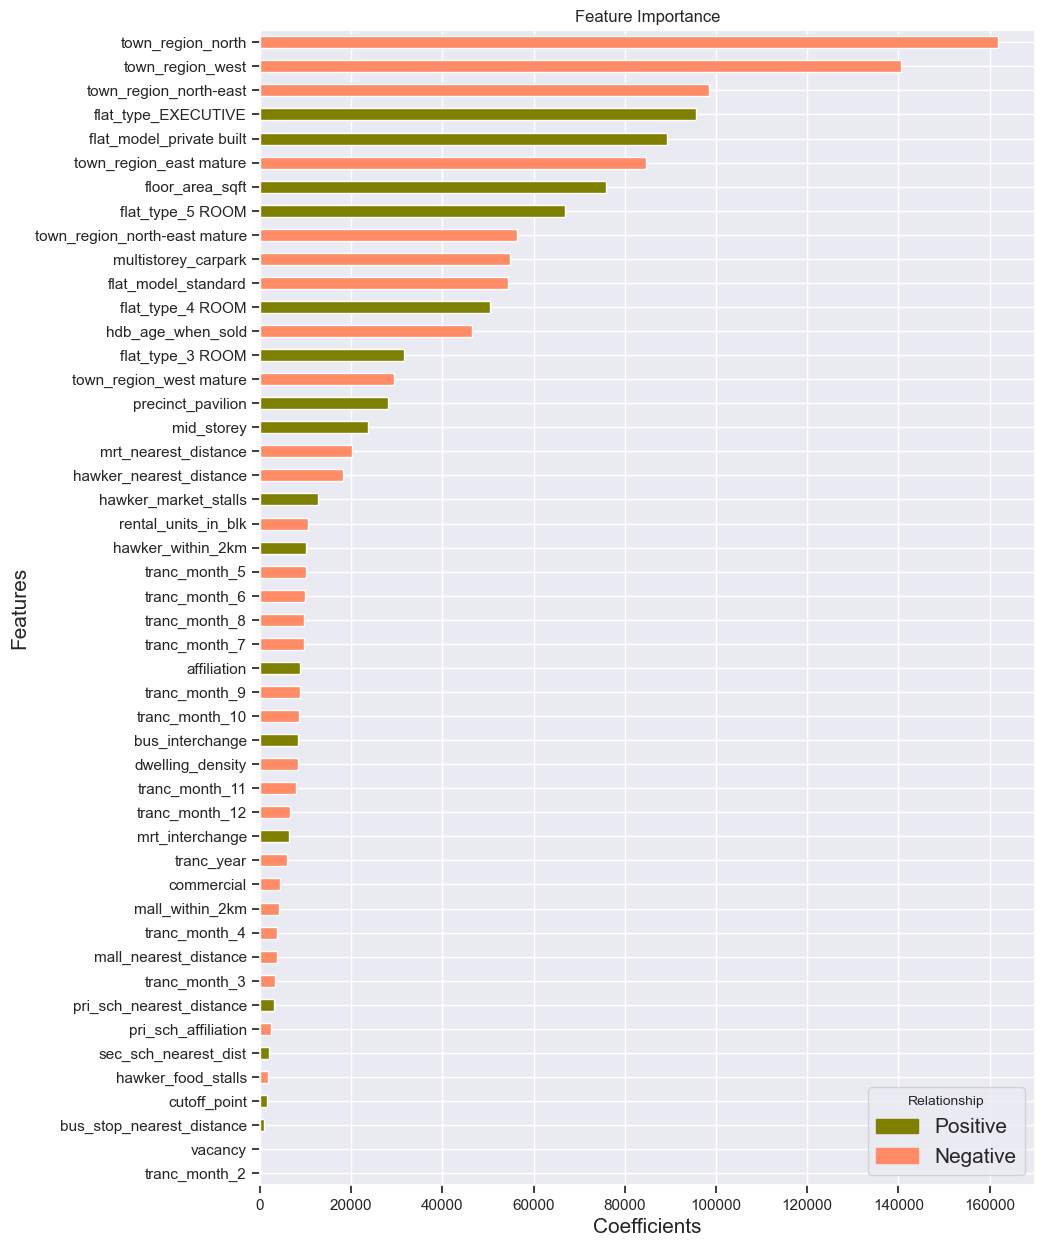

In [82]:
# create a new column in the df for absolute values
df_coeff["coefficients_abs"] = np.abs(df_coeff["coefficients"])
df_coeff = df_coeff.sort_values("coefficients_abs").reset_index(drop=True)

# colour the features according to if the value is positive or negative
df_coeff["color"] = df_coeff["coefficients"].apply(lambda x: "#808000" if x>0 else "#ff8c66")

# plot the bar chart
df_coeff.plot.barh(x = "feature", y = "coefficients_abs", color = df_coeff['color'], figsize=(10,15))

# for legend labelling
colors = {"Positive":"#808000", "Negative":"#ff8c66"}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = plt.legend(handles, labels, title="Relationship", fontsize = '15', loc = "lower right")
plt.setp(legend.get_title(),fontsize='10')

# for axis labelling
plt.xlabel("Coefficients", size=15), plt.ylabel("Features", size=15)
plt.title("Feature Importance")
plt.show();

### 9. Explaination of model chosen

For all 3 models, they predicted the same top 3 features that would influence resale prices - this meant that broadly speaking, the models are in congruence on the features that will affect resale prices.

However based on the summary table, we would choose to go with **Ridge regularization**.

Using Linear Regression as the baseline, it will seem that Lasso regularization will be the optimal choice as it has produced better R2 scores on both the training and test set as well as K-fold cross validation scores. However, if we look at the RMSE, it has the highest value - this would mean that the error between the predicted resale prices and the actual resale prices is the highest in Lasso regularization.

On the other hand, even though Ridge regularization has slightly higher R2 scores, it still performed better than linear regression. The train and test score difference is considered minimal - it means that the model still trained sufficiently well and there is only a very slight overfit on the test data. Most importantly, out of the 3 models, Ridge regularization has the lowest RMSE score - this is important as we would want a lower score so that the predicted resale prices would have a lower margin of error compared to the actual resale prices.

### 10. Recommendations & Conclusion

> Based on our problem statement, we came up with recommendations for 3 potential groups of buyers: 
1. Budget-concious
    - To consider purchasing units in the North region of Singapore as it generally has the lowest prices compared to the other regions, if location is not a concern
    - Likely due to towns in the North are non mature

2. Family-oriented
    - To consider 4-room, 5-room and executive flat types 
    - Can still cost-save by considering units the North, West and North-east regions

3. Design-concious
    - To consider looking at flat models instead of flat types and locations
    - Maisonette and private built flat models have bigger floor area, "luxrious feel"
    - However the trade-off is that prices might be higher than the standard HDB units

However there are also other potential factors that buyers can consider which are not reflected in our model, but could be important to them as well:
    - Noise i.e. surrounding ambient noise of the unit
    - HDB measures i.e. cooling measures, eligibility controls, ethnic quotas
    - Other preferential & community features i.e. corner units, orientation of unit, proximity to community amenities

> In conclusion,
1. Top considerations are regions and maturity of the estate that the HDB unit is located in
2. Followed by the unit specifications of flat type, flat model, floor area
3. Personal preferences

However, since HDB units are still under purview of public housing policy and the resale market is subject to policy changes and circumstances, buyers will have to keep these in mind.